Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

## objectif :

 * Réaliser une courte analyse exploratoire
 
 * Tester différents modèles de prédiction afin de répondre au mieux à la problématique.
 
**L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées)** 

**Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).**

**Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.**


**[Exploration des deux fichiers](#ex)**

**[Normalisation des noms entre les deux dataframes](#nm)**

**[Traitement des doublons](#db)**

**[Analyse des variables ](#an)**

**[Gestion des variables categorielle ](#cat)**

**[Corrélation des variables](#cat)**

**[Test de normalité Kolmogorov Smirnov](#nov)**

**[Analyse multivariee](#mul)**

**[Repartition geographique](#lat)**



# Objectif :

* comprendre du mieux possible nos donnees
* developper une strategie de modelisation

## Precision du jeux de donnees


**Analyse de Forme :**

* variable target : SiteEnergyUse et TotalGHGEmissions
* lignes et colonnes :

 * nous pouvons voir un identifiant unique commun sur la colonne <code>OSEBuildingID</code>
    
 * les informations de geolocalisation sont stockees de manieres differentes entre les fichiers 
 
 <code>Location</code> VS <code>Latitude,Longitude</code>
 * le fichier seattle 2015 a 3340 identifiants uniques , 56 identifiants ne sont pas referencee sur seattle 2016
 * le fichier seattle 2016 a 3376 identifiants uniques , 92 identifiants ne sont pas referencee sur seattle 2015
 * les deux fichiers seattle 2016 et seattle 2015 ont en commun 3284 identifiants
 * Apres deduplication nous avons 3376 lignes et 48 colonnes
    * types de variables : 
    * analyse des valeurs manquantes :
 

#### Analyse de Fond :
- **Visualisation de la target** :
    
   Les variables à prédire sont la consommation d'énergie du bâtiment (SiteEnergyUse(kBtu)) et ses émissions de CO2 (TotalGHGEmissions)
    



In [2]:
import math
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("bmh")

In [3]:
pd.set_option('display.max_columns', None ) #pour afficher toutes les colonnes
pd.set_option('display.max_rows', None ) #pour afficher toutes les lignes

In [4]:
#recuperation des relevees de consomation electriques pour la ville de seattle pour les annees 2015-2016
seat2015=pd.read_csv('2015-building-energy-benchmarking.csv', sep=",") #3340 rows × 47 columns
seat2016=pd.read_csv('2016-building-energy-benchmarking.csv', sep=",") #3376 rows × 46 columns

In [5]:
seat2015.name = 'seattle 2015'
seat2016.name = 'seattle 2016'

<a name='ex'></a>
# Exploration des deux fichiers

**Dictionnaire de donnees recupere a l adresse suivante  https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy**

||||
|:---|:---|:---|
|Variable|Meaning|Type|
|OSEBuildingID|unique identifier assigned to each property|string"number"|
|DataYear|Calendar year (January-December) represented by each data record|string"number"|
|BuildingType|City of Seattle building type classification|string"text"|
|PrimaryPropertyType|The primary use of a property (e.g. office, retail store)|string"text"|
|PropertyName|Official or common property name|string|
|TaxParcelIdentificationNumber|Property King County PIN|string"text"|
|CouncilDistrictCode|Property City of Seattle council district."|string"number"|
|Neighborhood|Property neighborhood area defined by the City of Seattle Department of Neighborhoods|string"text"|
|YearBuilt|Year in which a property was constructed or underwent a complete renovation.|string"number"|
|NumberofBuildings|Number of buildings included in the property's report. In cases where a property is reporting as a campus, multiple buildings may be included in one report|string"number"|
|NumberofFloors|Number of floors reported in Portfolio Manager|string"number"|
|PropertyGFATotal|Total building and parking gross floor area.|string"number"|
|PropertyGFAParking|Total space in square feet of all types of parking (Fully Enclosed, Partially Enclosed, and Open|string"number"|
|PropertyGFABuilding(s)|Total floor space in square feet between the outside surfaces of a building’s enclosing walls. This includes all areas inside the building(s), such as tenant space, common areas, stairwells, basements, storage, etc."|string"number"|
|ListOfAllPropertyUseTypes|All property uses reported in Portfolio Manager|string"text"|
|LargestPropertyUseType|The largest use of a property (e.g. office, retail store) by GFA.|string"text"|
|LargestPropertyUseTypeGFA|The gross floor area (GFA) of the largest use of the property|string"number"|
|SecondLargestPropertyUseType|The second largest use of a property (e.g. office, retail store) by GFA|string"text"|
|SecondLargestPropertyUseTypeGFA|The gross floor area (GFA) of the second largest use of the property|string"number"|
|ThirdLargestPropertyUseType|ThirdLargestPropertyUseType|string"text"|
|ThirdLargestPropertyUseTypeGFA|The third largest use of a property (e.g. office, retail store) by GFA|string"number"|
|YearsENERGYSTARCertified|yearsenergystarcertified|string"text"|
|ENERGYSTARScore|An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.|string"number"|
|SiteEUI(kBtu/sf)|Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area. Site Energy Use is the annual amount of all the energy consumed by the property on-site, as reported on utility bills. Site EUI is measured in thousands of British thermal units (kBtu) per square foot|string"number"|
|SiteEUIWN(kBtu/sf)|Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot."|string"number"|
|SourceEUI(kBtu/sf)|Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot|string"number"|
|string"SourceEUIWN(kBtu/sf)"|"Weather Normalized (WN) Source Energy Use Intensity (EUI) is a property's WN Source Energy divided by its gross floor area. WN Source Energy is the Source Energy Use the property would have consumed during 30-year average weather conditions. WN Source EUI is measured in measured in thousands of British thermal units (kBtu) per square foot."|string"number"|
|SiteEnergyUse(kBtu)|The annual amount of energy consumed by the property from all sources of energy|string"number"|
|SiteEnergyUseWN(kBtu)|The annual amount of energy consumed by the property from all sources of energy, adjusted to what the property would have consumed during 30-year average weather conditions.|string"number"|
|SteamUse(kBtu)|The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).|string"number"|
|Electricity(kWh)|The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in kWh|string"number"|
|Electricity(kBtu)|The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu)."|string"number"|
|NaturalGas(therms)|The annual amount of utility-supplied natural gas consumed by the property, measured in therms|string"number"|
|NaturalGas(kBtu)|The annual amount of utility-supplied natural gas consumed by the property, measured in thousands of British thermal units (kBtu)|string"number"|
|OtherFuelUse(kBtu)|OtherFuelUse(kBtu)|string"number"|
|GHGEmissions(MetricTonsCO2e)|The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.|string"number"|
|GHGEmissionsIntensity(kgCO2e/ft2)|Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources|string"number"|
|DefaultData|The property used default data for at least one property characteristic|string"text"|
|Comment|Comments by a building owner or agent to provide context to the building’s energy use|string"text"|
|ComplianceStatus|Whether a property has met energy benchmarking requirements for the current reporting year|string"text"|
|Outlier|Whether a property is a high or low outlier (Y/N)|string"text"|
|2010 Census Tracts|2010 Census Tracts|string"number"|
|Seattle Police Department Micro Community Policing Plan Areas|Seattle Police Department Micro Community Policing Plan Areas|string"number"|
|City Council Districts|City Council Districts|string"number"|
|SPD Beats|SPD Beats|string"number"|
|Zip Codes|Zip Codes|string"number"|
|Address|Address|string"text"|
|City|City|string"text"|
|State|State|string"text"|
|Latitude|Property latitude|string"number"|
|Longitude|Property longitude|string"number"|


In [6]:
print('le fichier {} a {} lignes et {} colonnes '.format(seat2015.name,seat2015.shape[0],seat2015.shape[1])) 
print('le fichier {} a {} lignes et {} colonnes '.format(seat2016.name,seat2016.shape[0],seat2016.shape[1])) 

le fichier seattle 2015 a 3340 lignes et 47 colonnes 
le fichier seattle 2016 a 3376 lignes et 46 colonnes 


In [7]:
seat2015[sorted(seat2015.columns)].dtypes

2010 Census Tracts                                               float64
BuildingType                                                      object
City Council Districts                                           float64
Comment                                                           object
ComplianceStatus                                                  object
CouncilDistrictCode                                                int64
DataYear                                                           int64
DefaultData                                                       object
ENERGYSTARScore                                                  float64
Electricity(kBtu)                                                float64
Electricity(kWh)                                                 float64
GHGEmissions(MetricTonsCO2e)                                     float64
GHGEmissionsIntensity(kgCO2e/ft2)                                float64
LargestPropertyUseType                             

In [8]:
seat2016[sorted(seat2016.columns)].dtypes

Address                             object
BuildingType                        object
City                                object
Comments                           float64
ComplianceStatus                    object
CouncilDistrictCode                  int64
DataYear                             int64
DefaultData                           bool
ENERGYSTARScore                    float64
Electricity(kBtu)                  float64
Electricity(kWh)                   float64
GHGEmissionsIntensity              float64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
Latitude                           float64
ListOfAllPropertyUseTypes           object
Longitude                          float64
NaturalGas(kBtu)                   float64
NaturalGas(therms)                 float64
Neighborhood                        object
NumberofBuildings                  float64
NumberofFloors                       int64
OSEBuildingID                        int64
Outlier    

**On peut remarquer que nous n avons pas les memes colonnes entre les deux fichiers**

In [9]:
seat2015[sorted(seat2015.columns)].head(3)

,2010 Census Tracts,BuildingType,City Council Districts,Comment,ComplianceStatus,CouncilDistrictCode,DataYear,DefaultData,ENERGYSTARScore,Electricity(kBtu),Electricity(kWh),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),LargestPropertyUseType,LargestPropertyUseTypeGFA,ListOfAllPropertyUseTypes,Location,NaturalGas(kBtu),NaturalGas(therms),Neighborhood,NumberofBuildings,NumberofFloors,OSEBuildingID,OtherFuelUse(kBtu),Outlier,PrimaryPropertyType,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,PropertyName,SPD Beats,Seattle Police Department Micro Community Policing Plan Areas,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),TaxParcelIdentificationNumber,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearBuilt,YearsENERGYSTARCertified,Zip Codes
0,NaN,NonResidential,NaN,NaN,Compliant,7,2015,No,65.0,3686160.0,1080307.0,249.43,2.64,Hotel,88434.0,Hotel,"{'latitude': '47.61219025', 'longitude': '-122...",1272388.0,12724.0,DOWNTOWN,1,12.0,1,0.0,NaN,Hotel,88434,0,88434,MAYFLOWER PARK HOTEL,31.0,14.0,NaN,NaN,78.9,80.3,6981428.0,7097539.0,173.5,175.1,2023032.0,659000030,NaN,NaN,1927,NaN,18081
1,NaN,NonResidential,NaN,NaN,Compliant,7,2015,No,51.0,3905411.0,1144563.0,263.51,2.38,Hotel,83880.0,"Hotel, Parking, Restaurant","{'latitude': '47.61310583', 'longitude': '-122...",4448985.0,44490.0,DOWNTOWN,1,11.0,2,0.0,NaN,Hotel,88502,15064,103566,PARAMOUNT HOTEL,31.0,14.0,Parking,15064.0,94.4,99.0,8354235.0,8765788.0,191.3,195.2,0.0,659000220,Restaurant,4622.0,1996,NaN,18081
2,NaN,NonResidential,NaN,NaN,Compliant,7,2015,Yes,18.0,49762435.0,14583930.0,2061.48,1.92,Hotel,757243.0,"Hotel, Parking, Swimming Pool","{'latitude': '47.61334897', 'longitude': '-122...",3709900.0,37099.0,DOWNTOWN,1,41.0,3,0.0,NaN,Hotel,961990,0,961990,WESTIN HOTEL,31.0,56.0,Parking,100000.0,96.6,99.7,73130656.0,75506272.0,242.7,246.5,19660404.0,659000475,Swimming Pool,0.0,1969,NaN,18081


In [10]:
seat2016[sorted(seat2016.columns)].head(3)

,Address,BuildingType,City,Comments,ComplianceStatus,CouncilDistrictCode,DataYear,DefaultData,ENERGYSTARScore,Electricity(kBtu),Electricity(kWh),GHGEmissionsIntensity,LargestPropertyUseType,LargestPropertyUseTypeGFA,Latitude,ListOfAllPropertyUseTypes,Longitude,NaturalGas(kBtu),NaturalGas(therms),Neighborhood,NumberofBuildings,NumberofFloors,OSEBuildingID,Outlier,PrimaryPropertyType,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,PropertyName,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),State,SteamUse(kBtu),TaxParcelIdentificationNumber,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,TotalGHGEmissions,YearBuilt,YearsENERGYSTARCertified,ZipCode
0,405 Olive way,NonResidential,Seattle,NaN,Compliant,7,2016,False,60.0,3946027.0,1.156514e+06,2.83,Hotel,88434.0,47.61220,Hotel,-122.33799,1276453.0,12764.52930,DOWNTOWN,1.0,12,1,NaN,Hotel,88434,0,88434,Mayflower park hotel,NaN,NaN,81.699997,84.300003,7226362.5,7456910.0,182.500000,189.000000,WA,2003882.0,0659000030,NaN,NaN,249.98,1927,NaN,98101.0
1,724 Pine street,NonResidential,Seattle,NaN,Compliant,7,2016,False,61.0,3242851.0,9.504252e+05,2.86,Hotel,83880.0,47.61317,"Hotel, Parking, Restaurant",-122.33393,5145082.0,51450.81641,DOWNTOWN,1.0,11,2,NaN,Hotel,88502,15064,103566,Paramount Hotel,Parking,15064.0,94.800003,97.900002,8387933.0,8664479.0,176.100006,179.399994,WA,0.0,0659000220,Restaurant,4622.0,295.86,1996,NaN,98101.0
2,1900 5th Avenue,NonResidential,Seattle,NaN,Compliant,7,2016,False,43.0,49526664.0,1.451544e+07,2.19,Hotel,756493.0,47.61393,Hotel,-122.33810,1493800.0,14938.00000,DOWNTOWN,1.0,41,3,NaN,Hotel,759392,196718,956110,5673-The Westin Seattle,NaN,NaN,96.000000,97.699997,72587024.0,73937112.0,241.899994,244.100006,WA,21566554.0,0659000475,NaN,NaN,2089.28,1969,NaN,98101.0


## Premiere observation :

 * nous pouvons voir un identifiant unique commun sur la colonne <code>OSEBuildingID</code>
    
 * les informations de geolocalisation sont stockees de manieres differentes entre les fichiers 
 <code>Location</code> VS <code>Latitude,Longitude</code>

<AxesSubplot:ylabel='None'>

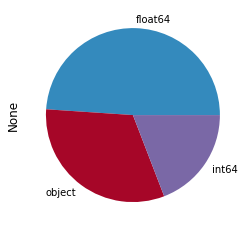

In [11]:
seat2015.dtypes.value_counts().plot.pie()

<AxesSubplot:ylabel='None'>

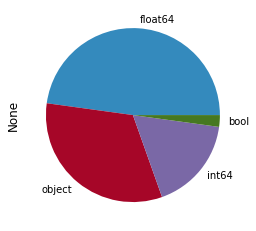

In [12]:
seat2016.dtypes.value_counts().plot.pie()

## verification de l unicite des identifiants

In [13]:
print('le fichier {} a {} identifiants uniques pour {} lignes'.format(seat2015.name,seat2015['OSEBuildingID'].nunique(),seat2015.shape[0]))
print('le fichier {} a {} identifiants uniques pour {} lignes'.format(seat2016.name,seat2016['OSEBuildingID'].nunique(),seat2016.shape[0]))

le fichier seattle 2015 a 3340 identifiants uniques pour 3340 lignes
le fichier seattle 2016 a 3376 identifiants uniques pour 3376 lignes


In [14]:
missingId2015 =[idx for idx in seat2015["OSEBuildingID"] if idx not in seat2016["OSEBuildingID"].values]
missingId2016 =[idx for idx in seat2016["OSEBuildingID"] if idx not in seat2015["OSEBuildingID"].values]
communId =[idx for idx in seat2016["OSEBuildingID"] if idx in seat2015["OSEBuildingID"].values]
print('le fichier {} a {} identifiants uniques , {} identifiants ne sont pas referencee sur {}'.format(seat2015.name,seat2015['OSEBuildingID'].nunique(),len(missingId2015),seat2016.name))
print('le fichier {} a {} identifiants uniques , {} identifiants ne sont pas referencee sur {}'.format(seat2016.name,seat2016['OSEBuildingID'].nunique(),len(missingId2016),seat2015.name))
print('les deux fichiers {} et {} ont en commun {} identifiants'.format(seat2016.name,seat2015.name,len(communId)))

le fichier seattle 2015 a 3340 identifiants uniques , 56 identifiants ne sont pas referencee sur seattle 2016
le fichier seattle 2016 a 3376 identifiants uniques , 92 identifiants ne sont pas referencee sur seattle 2015
les deux fichiers seattle 2016 et seattle 2015 ont en commun 3284 identifiants


Nous avons donc des identifiants unique par lignes pour chaque fichiers , ce qui est une bonne nouvelle, nous allons voir par la suite si il y a des identifiants en commun entre les deux fichiers, et voir ce que nous pouvons normaliser , comme la variables location par exemple

# verification des colonnes communes et differentes

In [15]:
def not_in_column(df1,df2):
    print('column from {} not in column from {} :'.format(df1.name,df2.name))
    print([col for col in df1[sorted(df1.columns)] if col not in df2[sorted(df2.columns)]])
    print('--------------------------------------------------------------')
     
not_in_column(seat2015,seat2016)   
not_in_column(seat2016,seat2015)  

column from seattle 2015 not in column from seattle 2016 :
['2010 Census Tracts', 'City Council Districts', 'Comment', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Location', 'OtherFuelUse(kBtu)', 'SPD Beats', 'Seattle Police Department Micro Community Policing Plan Areas', 'Zip Codes']
--------------------------------------------------------------
column from seattle 2016 not in column from seattle 2015 :
['Address', 'City', 'Comments', 'GHGEmissionsIntensity', 'Latitude', 'Longitude', 'State', 'TotalGHGEmissions', 'ZipCode']
--------------------------------------------------------------


On peut remarquer quelques informations interessante :

   * <code>Zip Codes</code> et<code>ZipCode</code> peuvent correspondre aux memes data
   * <code>Comments</code> et <code>Comment</code> peuvent correspondre aux memes data
   * <code>City Council Districts</code> et <code>City</code> peuvent etre liee
   * <code>GHGEmissionsIntensity (kgCO2e/ft2)</code> et <code>GHGEmissionsIntensity</code> peuvent correspondre aux memes data 
   * <code>GHGEmissions(MetricTonsCO2e)</code> et <code>TotalGHGEmissions</code> peuvent correspondre aux memes data    
   * <code>Seattle Police Department Micro Community Policing Plan Areas</code> semble interessante a conserver
   * nous pouvons re creer deux colonne <code>Latitude Longitude</code> a partir <code>Location</code> ainsi que d autres informations 

In [16]:
def in_column(df1,df2):
    print('commun column from {} with {} :'.format(df1.name,df2.name))
    return [col for col in df1[sorted(df1.columns)] if col in df2[sorted(df2.columns)]]
in_column(seat2015,seat2016)    

commun column from seattle 2015 with seattle 2016 :


['BuildingType',
 'ComplianceStatus',
 'CouncilDistrictCode',
 'DataYear',
 'DefaultData',
 'ENERGYSTARScore',
 'Electricity(kBtu)',
 'Electricity(kWh)',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'ListOfAllPropertyUseTypes',
 'NaturalGas(kBtu)',
 'NaturalGas(therms)',
 'Neighborhood',
 'NumberofBuildings',
 'NumberofFloors',
 'OSEBuildingID',
 'Outlier',
 'PrimaryPropertyType',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'PropertyGFATotal',
 'PropertyName',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SteamUse(kBtu)',
 'TaxParcelIdentificationNumber',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearBuilt',
 'YearsENERGYSTARCertified']

<a name='nm'></a>
# normalisation des noms entre les deux dataframes

**redefinition du typeZipCode**

In [17]:
seat2016['ZipCode'] = seat2016['ZipCode'].fillna(0)

In [18]:
seat2016['ZipCode'] = seat2016['ZipCode'].astype('int')

**renommage de comment**

In [19]:
seat2015.rename(columns={'Comment': 'Comments'}, inplace=True)

In [20]:
#ranommage de zipCode
seat2015.rename(columns={'Zip Codes': 'ZipCode'},inplace=True)

**renommage de GHGEmissions(MetricTonsCO2e)**

In [21]:
seat2015.rename(columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions'},inplace=True)

**renommage de GHGEmissionsIntensity(kgCO2e/ft2)**

In [22]:
seat2015.rename(columns={'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'},inplace=True)

**creation de <code>Latitude,Longitude,address,city,state,ZipCode2</code> a partir de <code>Location</code>**

In [23]:
seat2015['Location'].head(1).tolist()

['{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}']

In [24]:
def getExtracolumns(df, name):
    latlist, lglist, address,city,state,zipCode = ([] for i in range(6))
    for location in df[name]:
        location = location.replace('"',"'")
        latlist.append(location.split(":")[1].split("'")[1])
        lglist.append(location.split(":")[2].split("'")[1])
        address.append(location.split(":")[4].split("'")[1])
        city.append(location.split(":")[5].split("'")[1])
        state.append(location.split(":")[6].split("'")[1])
        zipCode.append(location.split(":")[7].split("'")[1])
    return latlist, lglist,  address,city,state,zipCode

seat2015["Latitude"],seat2015["Longitude"],seat2015["Address"],seat2015["City"],seat2015["State"],seat2015["ZipCode"] = getExtracolumns(seat2015,'Location')
seat2015['Latitude'] = seat2015['Latitude'].astype('float')
seat2015['Longitude'] = seat2015['Longitude'].astype('float')

In [25]:
seat2015[['Longitude','Latitude','Address','City','State','ZipCode']].head()

,Longitude,Latitude,Address,City,State,ZipCode
0,-122.337997,47.612190,405 OLIVE WAY,SEATTLE,WA,98101
1,-122.333358,47.613106,724 PINE ST,SEATTLE,WA,98101
2,-122.337699,47.613349,1900 5TH AVE,SEATTLE,WA,98101
3,-122.336609,47.614216,620 STEWART ST,SEATTLE,WA,98101
4,-122.340924,47.613754,401 LENORA ST,SEATTLE,WA,98121


on peut maintenand suprimmer la colonne <code>location</code>

In [26]:
seat2015.drop(columns=['Location'], inplace=True)

# Information sur les  colonnes restantes

In [27]:
def not_in_column2(df1,df2):
    print('column from {} not in column from {} :'.format(df1.name,df2.name))
    return [col for col in df1[sorted(df1.columns)] if col not in df2[sorted(df2.columns)]]
print(not_in_column2(seat2015,seat2016)   )
print(not_in_column2(seat2016,seat2015)  )

column from seattle 2015 not in column from seattle 2016 :
['2010 Census Tracts', 'City Council Districts', 'OtherFuelUse(kBtu)', 'SPD Beats', 'Seattle Police Department Micro Community Policing Plan Areas']
column from seattle 2016 not in column from seattle 2015 :
[]


**Analysons les colonnes restantes present dans le fichier 2015 et pas 2016**

In [28]:
(seat2015[not_in_column2(seat2015,seat2016)].notna().mean(axis=0)*100).sort_values(ascending=True)

column from seattle 2015 not in column from seattle 2016 :


City Council Districts                                            6.377246
2010 Census Tracts                                                6.706587
OtherFuelUse(kBtu)                                               99.700599
SPD Beats                                                        99.940120
Seattle Police Department Micro Community Policing Plan Areas    99.940120
dtype: float64

In [29]:
# City Council Districts et 2010 Census Tracts sont peu remplis ont les supprime
seat2015.drop(columns=['City Council Districts','2010 Census Tracts'], inplace=True)

In [30]:
#la colonne OtherFuelUse(kBtu) ne contient pas beaucoup de valeurs, suppression
len(seat2015[seat2015['OtherFuelUse(kBtu)'] <= 0])

3313

In [31]:
#on la supprime egalement
seat2015.drop(columns=['OtherFuelUse(kBtu)'], inplace=True)

In [32]:
seat2015[not_in_column2(seat2015,seat2016)].head()

column from seattle 2015 not in column from seattle 2016 :


,SPD Beats,Seattle Police Department Micro Community Policing Plan Areas
0,31.0,14.0
1,31.0,14.0
2,31.0,56.0
3,31.0,56.0
4,31.0,56.0


In [33]:
#on fait le choix de  les sauvegarde pour l instant
lis =['OSEBuildingID'] + not_in_column2(seat2015,seat2016) 
other = seat2015[lis]

column from seattle 2015 not in column from seattle 2016 :


In [34]:
other.shape

(3340, 3)

**suppression des colonnes differentes afin de pouvoir les concatener**

In [35]:
seat2015.drop(columns=['SPD Beats','Seattle Police Department Micro Community Policing Plan Areas'], inplace=True)

In [36]:
seat2015.shape

(3340, 46)

In [37]:
seat2016.shape

(3376, 46)

<a name='db'></a>
# traitement des doublons

**Nous faisons un concat entre nos deux dataframe, et dedupliquons en gardans les valeurs maximum**

Nous allons donc travailler sur nos donnees merger afin de recuperer tous nos identifiants des deux dataframe , et ensuite nous faisons un regroupement sur l id et recuperons les valeurs les plus grandes pour un batiment en question.


In [38]:
#concatenation des deux fichiers avec la methode concat
seattle = pd.concat([seat2015,seat2016])
#deduplication sur l id avec conservation des valeurs maximum
seattle_dedup = (seattle.sort_values(by='OSEBuildingID', ascending=False)
   .groupby(level=0)
   .head(1)
   .sort_index())
seattle_dedup.shape

(3376, 46)

une fois nos identifiants commun sont concatener , nous allons recuperer les identifiants nos presents sur les fichiers 2015 et 2016 pour les ajouter a notre nouveau jeux de donnees 

In [39]:
missingId2015 =[idx for idx in seat2015["OSEBuildingID"] if idx not in seattle_dedup["OSEBuildingID"].values]
missingId2016 =[idx for idx in seat2016["OSEBuildingID"] if idx not in seattle_dedup["OSEBuildingID"].values]
print('le fichier {} a {} identifiants uniques , {} identifiants ne sont pas referencee sur {}'.format(seat2015.name,seat2015['OSEBuildingID'].nunique(),len(missingId2015),'seattle_dedup'))
print('le fichier {} a {} identifiants uniques , {} identifiants ne sont pas referencee sur {}'.format(seat2016.name,seat2016['OSEBuildingID'].nunique(),len(missingId2016),'seattle_dedup'))

le fichier seattle 2015 a 3340 identifiants uniques , 55 identifiants ne sont pas referencee sur seattle_dedup
le fichier seattle 2016 a 3376 identifiants uniques , 2 identifiants ne sont pas referencee sur seattle_dedup


In [40]:
t1 = seat2015[seat2015['OSEBuildingID'].isin(missingId2015)]
t2 = seat2016[seat2016['OSEBuildingID'].isin(missingId2016)]
seattle_dedup = seattle_dedup.append(t1) 
seattle_dedup = seattle_dedup.append(t2)
print(seattle_dedup.shape)

(3433, 46)


/tmp/ipykernel_13915/947138848.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seattle_dedup = seattle_dedup.append(t1)
/tmp/ipykernel_13915/947138848.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seattle_dedup = seattle_dedup.append(t2)


**Nous avons donc apres dedoublonnage 3433 batiments avec 46 colonnes pour l instant**

In [41]:
print('le dataframe seattle a  {} lignes et  colonnes {}'.format(seattle.shape[0],seattle.shape[1]))
print('le dataframe seattle dedup a {} lignes et colonnes {}'.format(seattle_dedup.shape[0],seattle_dedup.shape[1]))

le dataframe seattle a  6716 lignes et  colonnes 46
le dataframe seattle dedup a 3433 lignes et colonnes 46


**Comparons nos identifiants afin de verifier si les valeurs maximum sont bien pris en compte**

In [42]:
seattle[seattle["OSEBuildingID"] == 1]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,ZipCode,Latitude,Longitude,Address,City,State
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.900000,80.300000,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.00,3686160.0,12724.0000,1272388.0,249.43,2.64,No,NaN,Compliant,NaN,98101,47.61219,-122.337997,405 OLIVE WAY,SEATTLE,WA
0,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.5,189.0,7226362.5,7456910.0,2003882.0,1156514.25,3946027.0,12764.5293,1276453.0,249.98,2.83,False,NaN,Compliant,NaN,98101,47.61220,-122.337990,405 Olive way,Seattle,WA


In [43]:
seattle_dedup[seattle_dedup["OSEBuildingID"] == 1]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,ZipCode,Latitude,Longitude,Address,City,State
0,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.5,189.0,7226362.5,7456910.0,2003882.0,1156514.25,3946027.0,12764.5293,1276453.0,249.98,2.83,False,NaN,Compliant,NaN,98101,47.6122,-122.33799,405 Olive way,Seattle,WA


In [44]:
# seattle_dedup['SPD_Beats'] = other['SPD Beats']
# seattle_dedup['Plan_Area'] = other['Seattle Police Department Micro Community Policing Plan Areas']

In [45]:
seattle = seattle_dedup.copy()
seattle.shape

(3433, 46)

In [46]:
seattle.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData', 'Comments',
       'ComplianceStatus', 'Outlier', 'ZipCode', 'Latitude',

In [47]:
seattle.shape

(3433, 46)

In [48]:
#voir qund on merge les deux collones restantes
# seattle = pd.merge(seattle, other,how='left',on="OSEBuildingID")


<a name='an'></a>
# analyse des variables 

**Distribution de nos variables**

In [49]:
seattle['CouncilDistrictCode'] = seattle['CouncilDistrictCode'].astype('object')
qualitativescol = sorted(list(seattle.select_dtypes(include=['object', 'bool']).columns))
quantitativescol = sorted(list(seattle.select_dtypes(include=['float', 'int']).columns))
quantitativescol.remove('OSEBuildingID')

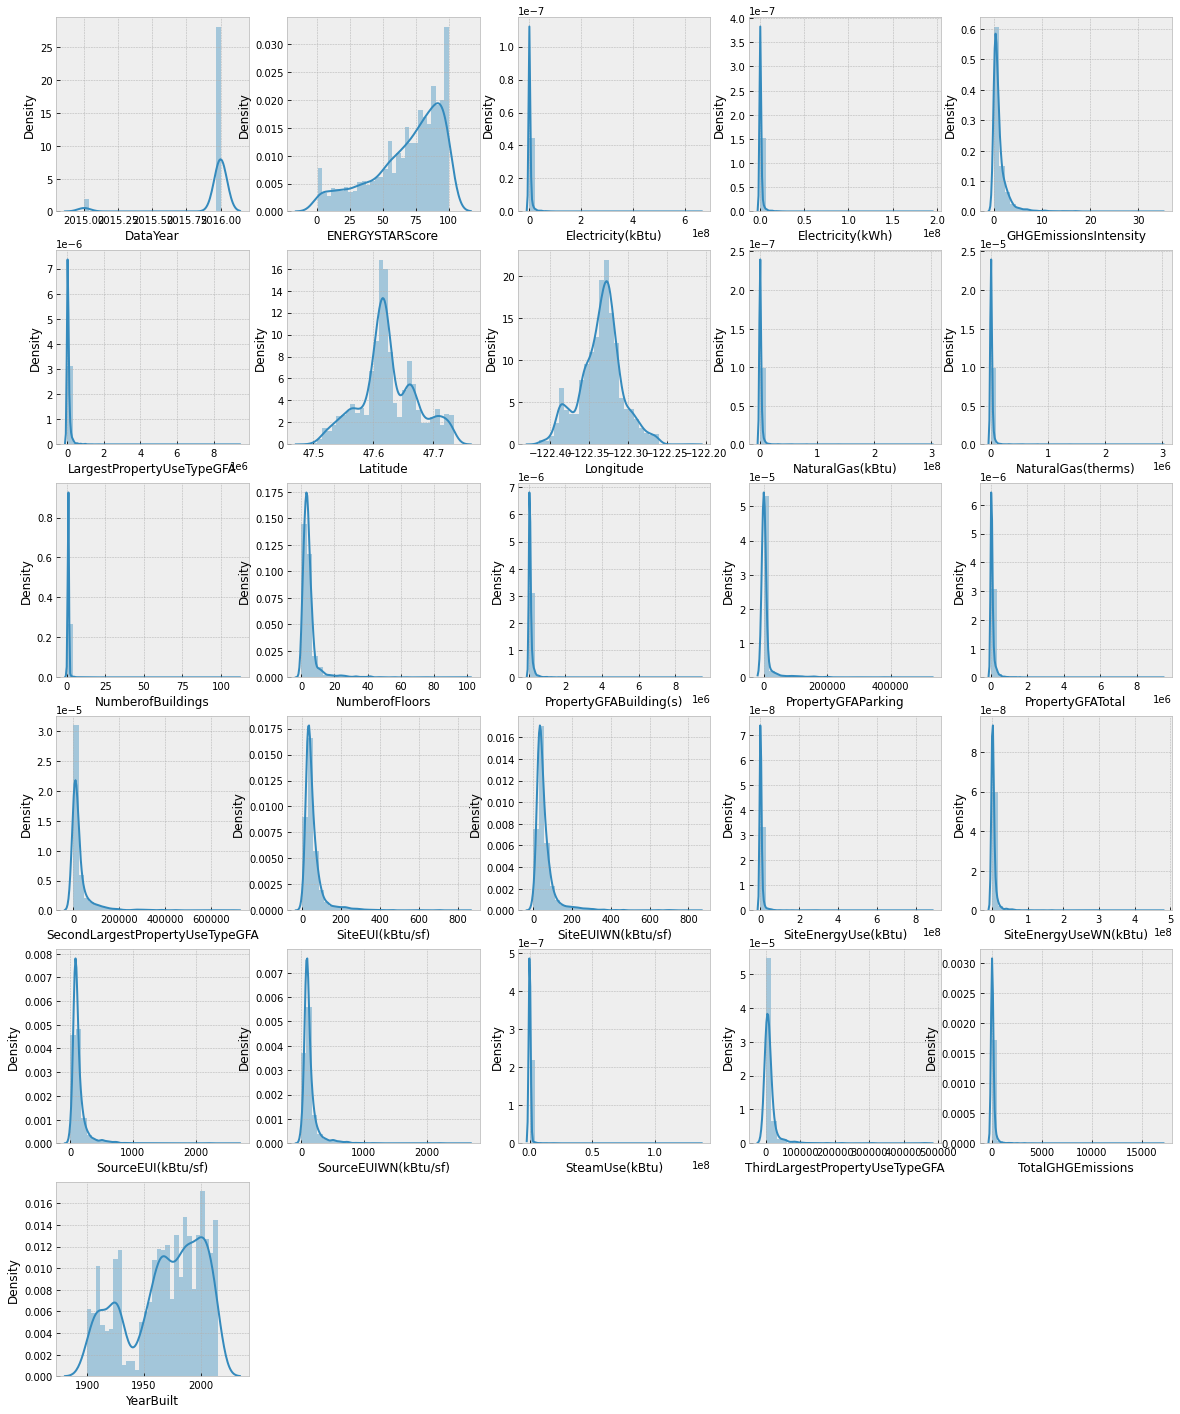

In [50]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(1, figsize=(20, 25))
for  i,label in  enumerate(sorted(quantitativescol)):
    plt.subplot(6, 5, i+1)
    sns.distplot(seattle[label], bins=30)
plt.show()

**La distribution de nos variables ne sont pas normal**

<code>Electricity(kWh)</code> et <code>Electricity(kBtu)</code> semblent redondant

<code>NaturalGas(therms)</code> et <code>NaturalGas(kBtu)</code> semblent redondant

Les variables contenant <code>WN</code> contiennent des releves associees a la meteo, non necessaire pour notre etude

In [51]:
#repatition des variables qualitative
for col in qualitativescol:
    print(f'{col :-<50} {seattle[col].nunique()}')

Address------------------------------------------- 3412
BuildingType-------------------------------------- 8
City---------------------------------------------- 2
Comments------------------------------------------ 2
ComplianceStatus---------------------------------- 4
CouncilDistrictCode------------------------------- 7
DefaultData--------------------------------------- 4
LargestPropertyUseType---------------------------- 57
ListOfAllPropertyUseTypes------------------------- 468
Neighborhood-------------------------------------- 19
Outlier------------------------------------------- 4
PrimaryPropertyType------------------------------- 31
PropertyName-------------------------------------- 3421
SecondLargestPropertyUseType---------------------- 49
State--------------------------------------------- 1
TaxParcelIdentificationNumber--------------------- 3324
ThirdLargestPropertyUseType----------------------- 43
YearsENERGYSTARCertified-------------------------- 64
ZipCode----------------------

In [52]:
#repatition des variables quantitatives
for col in quantitativescol:
    print(f'{col :-<50} ')

DataYear------------------------------------------ 
ENERGYSTARScore----------------------------------- 
Electricity(kBtu)--------------------------------- 
Electricity(kWh)---------------------------------- 
GHGEmissionsIntensity----------------------------- 
LargestPropertyUseTypeGFA------------------------- 
Latitude------------------------------------------ 
Longitude----------------------------------------- 
NaturalGas(kBtu)---------------------------------- 
NaturalGas(therms)-------------------------------- 
NumberofBuildings--------------------------------- 
NumberofFloors------------------------------------ 
PropertyGFABuilding(s)---------------------------- 
PropertyGFAParking-------------------------------- 
PropertyGFATotal---------------------------------- 
SecondLargestPropertyUseTypeGFA------------------- 
SiteEUI(kBtu/sf)---------------------------------- 
SiteEUIWN(kBtu/sf)-------------------------------- 
SiteEnergyUse(kBtu)------------------------------- 
SiteEnergyUs

<AxesSubplot:>

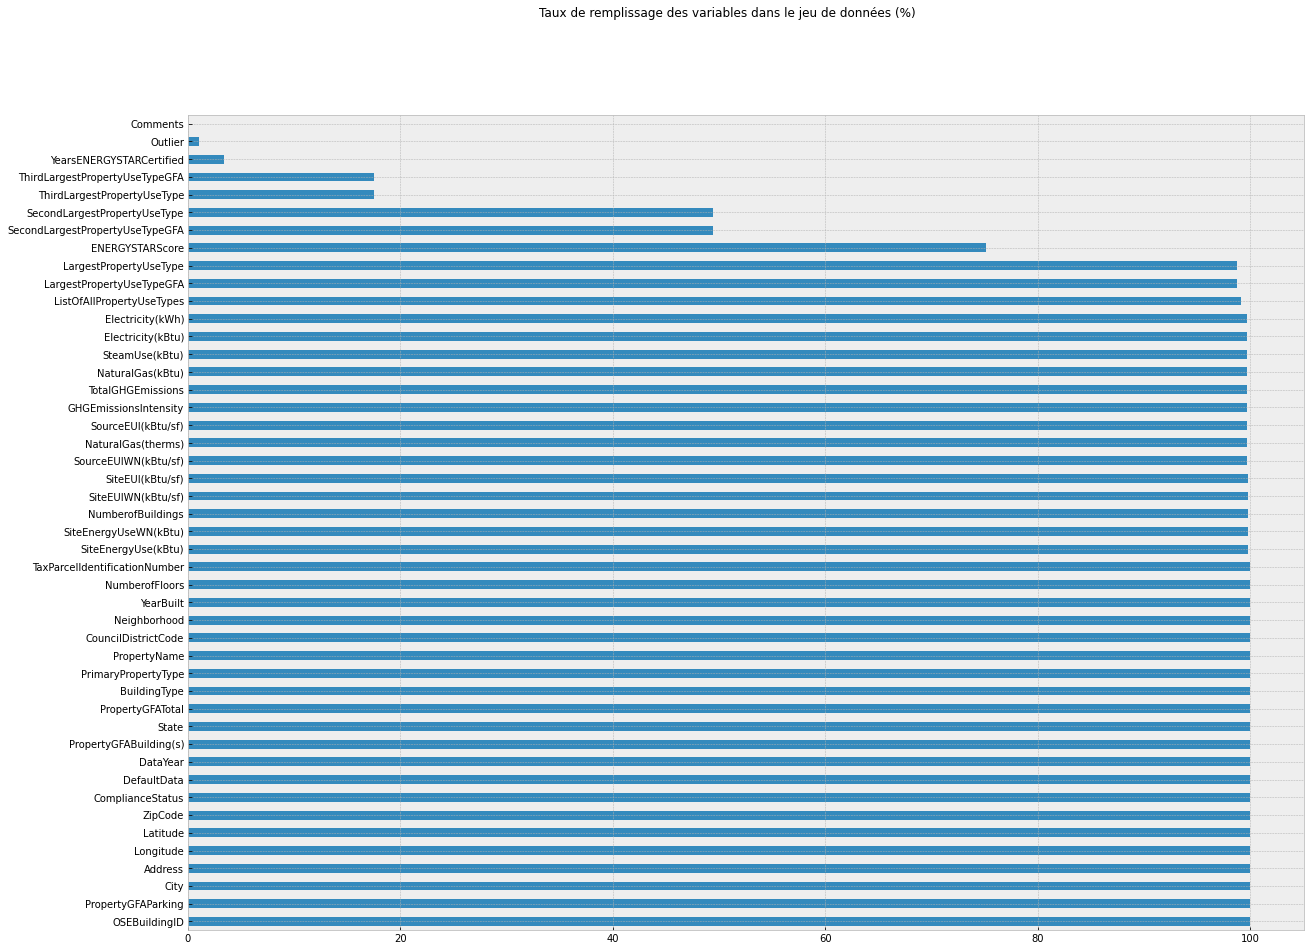

In [53]:
taux = (seattle.notna().mean(axis=0)*100).sort_values(ascending=False)
plt.suptitle("Taux de remplissage des variables dans le jeu de données (%)")
taux.plot(kind='barh', figsize=(20, 15))

**Nous devons predire les emissions de co2 et la consomation electrique des batiments, suppression de colonne inutile**

 * supression des features redondantes

Explication des variables
Plusieurs variables concernent les surfaces (GFA = Gross floor area) :

Gross floor area : surface totale

PropertyGFAParking : surface des parkings

PropertyGFABuilding(s) : surface des bâtiments

ListOfAllPropertyUseTypes : les différentes utilisations des surfaces (Hotel, Parking, Restaurant, Piscine, etc.)

LargestPropertyUseType / LargestPropertyUseTypeGFA : principale destination du bâtiment et sa surface

SecondLargestPropertyUseType / SecondLargestPropertyUseTypeGFA : seconde destination du bâtiment et sa surface

ThirdLargestPropertyUseType / ThirdLargestPropertyUseTypeGFA : troisième destination du bâtiment et sa surface

Concernant l'énergie, ENERGY STAR nous indique :

SiteEUI(kBtu/sf) / SiteEUIWN(kBtu/sf) : Energy Use Intensity (EUI) ou intensité de la consommation d'énergie ; l'EUI exprime la consommation d'énergie d'un bâtiment en fonction de sa taille ou d'autres caractéristiques.

SourceEUI(kBtu/sf) SourceEUIWN(kBtu/sf) : la source d'énergie est l'unité d'évaluation la plus équitable pour comparer différents bâtiments entre eux. La source d'énergie représente la quantité totale de combustible brut nécessaire au fonctionnement du bâtiment. Il intègre toutes les pertes de transmission, de livraison et de production. En prenant en compte toutes les consommations d'énergie, le score fournit une évaluation complète de l'efficacité énergétique d'un bâtiment.

SiteEnergyUse(kBtu) SiteEnergyUseWN(kBtu) SteamUse(kBtu) Electricity(kWh) Electricity(kBtu) NaturalGas(therms) NaturalGas(kBtu) : l'utilisation des énergies est exprimée en diverses unités :

kBTu : le B.T.U. (British Thermal Unit) est une unité de mesure d'énergie thermique. Le BTU, de symbole Btu, est utilisé dans les pays anglo-saxons et asiatiques et équivaut à 1055,06 Joule ou 252 calories.
1 BTU est l’énergie nécessaire pour chauffer ou refroidir une livre d’eau de 1 degré Fahrenheit au niveau de la mer.

Pour convertir une puissance en Btu une puissance en watt il suffit de diviser la puissance en Btu par 3414,5 pour obtenir la puissance en Kw.

therms : le therm est une unité d'énergie thermique anglo-saxone égale à 1 000 000 unités thermiques britanniques (BTU).

1 kWh = 0.034095106405145 thm
1 thm = 29.329722222222 kWh

Les suffixes WN : "Weather Normalized" - Mesures normalisées avec les conditions climatiques, inutile pour notre etude...

In [54]:
#sup
seattle.drop([col for col in seattle.columns if 'WN' in col], axis=1, inplace=True)

 <code>Electricity(kBtu)</code> et <code>Electricity(kWh)</code>, contiennennt les memes valeurs avec des unitees differrentes :

In [55]:
seattle.drop(['NaturalGas(therms)','Electricity(kWh)'], axis=1, inplace=True)

In [56]:
seattle = seattle[seattle.columns[seattle.isna().sum()/seattle.shape[0] < 0.9]]

In [57]:
deletecol = ["PropertyName","TaxParcelIdentificationNumber","GHGEmissionsIntensity"]
seattle.drop(columns=deletecol, inplace=True)

on peut remarquer que quelques colonnes quantitatives sont liees comme <code>SecondLargestPropertyUseType</code> et <code>SecondLargestPropertyUseTypeGFA</code>

In [58]:
seattle["SecondLargestPropertyUseType"].fillna("Unknow", inplace=True)
seattle["SecondLargestPropertyUseTypeGFA"].fillna(0, inplace=True)
seattle["ThirdLargestPropertyUseType"].fillna("Unknow", inplace=True)
seattle["ThirdLargestPropertyUseTypeGFA"].fillna(0, inplace=True)

In [59]:
# deletecol = ['Electricity(kWh)', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'PropertyGFATotal']
# seattle.drop(columns=deletecol,inplace=True)

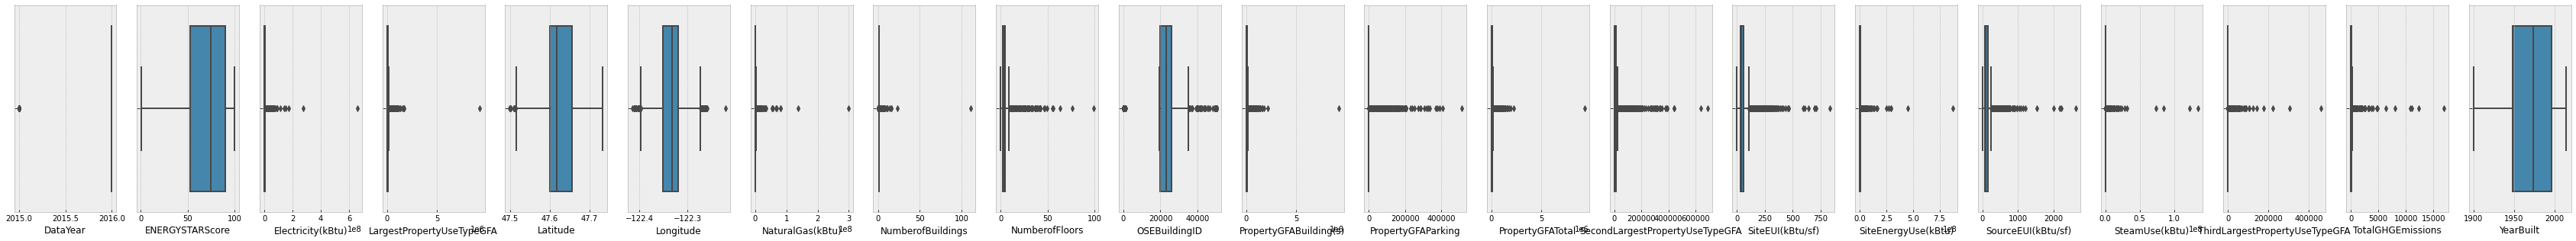

In [60]:
fig = plt.figure(1, figsize=(60, 5))
quantitativescol = sorted(list(seattle.select_dtypes(include=['float', 'int']).columns))
for i,label in enumerate(quantitativescol) :
    plt.subplot(1,len(quantitativescol), i+1)
    sns.boxplot(seattle[label], orient="v")
plt.show()

In [61]:
seattle.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,DefaultData,ComplianceStatus,ZipCode,Latitude,Longitude,Address,City,State
0,1,2016,NonResidential,Hotel,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,Unknow,0.0,Unknow,0.0,60.0,81.699997,182.5,7226362.5,2003882.0,3946027.0,1276453.0,249.98,False,Compliant,98101,47.612200,-122.337990,405 Olive way,Seattle,WA
1,2,2015,NonResidential,Hotel,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,51.0,94.400000,191.3,8354235.0,0.0,3905411.0,4448985.0,263.51,No,Compliant,98101,47.613106,-122.333358,724 PINE ST,SEATTLE,WA
2,3,2015,NonResidential,Hotel,7,DOWNTOWN,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,18.0,96.600000,242.7,73130656.0,19660404.0,49762435.0,3709900.0,2061.48,Yes,Compliant,98101,47.613349,-122.337699,1900 5TH AVE,SEATTLE,WA
3,5,2015,NonResidential,Hotel,7,DOWNTOWN,1926,1.0,10.0,61320,0,61320,Hotel,Hotel,61320.0,Unknow,0.0,Unknow,0.0,1.0,460.400000,636.3,28229320.0,23458518.0,2769023.0,2001894.0,1936.34,No,Compliant,98101,47.614216,-122.336609,620 STEWART ST,SEATTLE,WA
4,8,2015,NonResidential,Hotel,7,DOWNTOWN,1980,1.0,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,67.0,120.100000,228.8,14829099.0,0.0,6066245.0,8763105.0,507.70,No,Compliant,98121,47.613754,-122.340924,401 LENORA ST,SEATTLE,WA


suppression des colonnes remplis a moins de 10 %

In [62]:
seattle['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [63]:
seattle['BuildingType'].value_counts()

NonResidential          1489
Multifamily LR (1-4)    1040
Multifamily MR (5-9)     584
Multifamily HR (10+)     110
SPS-District K-12         99
Nonresidential COS        85
Campus                    25
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [64]:
seattle.shape

(3433, 35)

In [65]:
seattle[((seattle['SiteEnergyUse(kBtu)'].isna()) & (seattle['TotalGHGEmissions'].isna()))].shape

(7, 35)

Suppression des valeurs null de nos variables cible :

In [66]:
seattle[seattle["SiteEnergyUse(kBtu)"].isna()].shape

(7, 35)

**outliers:**

In [67]:
def delete_interval(val,min_,max_):
    if(math.isnan(val)):
        pass
    elif (val<=min_ or val>=max_):
        return(np.nan)
    else :
        return(val)

In [68]:
#batiments jusqu a 2016
seattle['YearBuilt']=seattle['YearBuilt'].apply(delete_interval, args=[1900,2016])
# 101 story-Building in Seattle (internet search)
seattle['NumberofFloors']=seattle['NumberofFloors'].apply(delete_interval, args=[0,100])
#outier fixer a 3 10^6
# seattle['PropertyGFATotal']=seattle['PropertyGFATotal'].apply(delete_interval, args=[0,3000000])
# pas negatif
# seattle['PropertyGFAParking']=seattle['PropertyGFAParking'].apply(delete_interval, args=[0,max(seattle['PropertyGFAParking'])])
#outier fixer a 3 10^6
seattle['PropertyGFABuilding(s)']=seattle['PropertyGFABuilding(s)'].apply(delete_interval, args=[0,3000000])
#interval 0-100
seattle['ENERGYSTARScore']=seattle['ENERGYSTARScore'].apply(delete_interval, args=[0,100])
#outier fixer a 3 10^8
seattle['SiteEnergyUse(kBtu)']=seattle['SiteEnergyUse(kBtu)'].apply(delete_interval, args=[0,300000000])
#outier fixer a 12500
seattle['TotalGHGEmissions']=seattle['TotalGHGEmissions'].apply(delete_interval, args=[0,12500])

In [69]:
seattle = seattle[~((seattle['SiteEnergyUse(kBtu)'].isnull()) | (seattle['TotalGHGEmissions'].isnull()))]
seattle.shape

(3404, 35)

In [70]:
qualitativescol = sorted(list(seattle.select_dtypes(include=['object', 'bool']).columns))
quantitativescol = sorted(list(seattle.select_dtypes(include=['float', 'int']).columns))

In [71]:
(seattle.isna().sum()/seattle.shape[0]).sort_values(ascending=True)

OSEBuildingID                      0.000000
Address                            0.000000
Longitude                          0.000000
Latitude                           0.000000
ZipCode                            0.000000
ComplianceStatus                   0.000000
DefaultData                        0.000000
TotalGHGEmissions                  0.000000
NaturalGas(kBtu)                   0.000000
Electricity(kBtu)                  0.000000
SteamUse(kBtu)                     0.000000
SiteEnergyUse(kBtu)                0.000000
SourceEUI(kBtu/sf)                 0.000000
SiteEUI(kBtu/sf)                   0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
City                               0.000000
ThirdLargestPropertyUseType        0.000000
SecondLargestPropertyUseType       0.000000
DataYear                           0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
CouncilDistrictCode                0.000000
Neighborhood                    

In [72]:
seattle.shape

(3404, 35)

les variables à prédire sont la consommation d'énergie du bâtiment (SiteEnergyUse(kBtu)) et ses émissions de CO2 (TotalGHGEmissions). supression des valeurs manquantes

In [73]:
seattle = seattle.reset_index(drop=True)

In [74]:
seattle.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Latitude,Longitude
count,3404.000000,3404.000000,3348.000000,3404.000000,3389.000000,3.404000e+03,3404.000000,3.404000e+03,3.371000e+03,3404.000000,3404.000000,2464.000000,3404.000000,3404.000000,3.404000e+03,3.404000e+03,3.404000e+03,3.404000e+03,3404.000000,3404.000000,3404.000000
mean,21204.278790,2015.938895,1969.513441,1.064924,4.725583,9.163643e+04,8165.133373,8.347129e+04,7.584206e+04,13738.866127,1903.014424,66.567370,55.005317,134.931257,5.070936e+06,2.596968e+05,3.493689e+06,1.293052e+06,113.075220,47.624095,-122.334816
std,12168.812188,0.239557,32.274426,0.807810,5.479133,1.488257e+05,32991.428075,1.319251e+05,1.220013e+05,37597.701928,10326.590218,26.516688,57.136700,139.720398,1.381347e+07,3.648474e+06,9.406205e+06,4.509174e+06,420.693874,0.047776,0.027110
min,1.000000,2015.000000,1901.000000,0.000000,1.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.400000,0.000000,1.340900e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.090000,47.499170,-122.414250
25%,19998.000000,2016.000000,1950.000000,1.000000,2.000000,2.837700e+04,0.000000,2.757850e+04,2.500000e+04,0.000000,0.000000,51.000000,27.900000,74.800003,9.355344e+05,0.000000e+00,6.425888e+05,0.000000e+00,9.480000,47.599868,-122.350445
50%,23112.000000,2016.000000,1976.000000,1.000000,4.000000,4.409200e+04,0.000000,4.313000e+04,3.954100e+04,0.000000,0.000000,73.000000,38.599998,96.199997,1.807103e+06,0.000000e+00,1.182026e+06,3.165590e+05,33.920000,47.618665,-122.332610
75%,25992.500000,2016.000000,1997.000000,1.000000,5.000000,9.044875e+04,0.000000,8.403450e+04,7.519400e+04,10600.000000,0.000000,88.000000,60.599998,144.000000,4.226081e+06,0.000000e+00,2.810274e+06,1.181576e+06,94.070000,47.657157,-122.319564
max,50226.000000,2016.000000,2015.000000,23.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,441551.000000,303910.000000,99.000000,834.400024,2620.000000,2.958126e+08,1.349435e+08,2.745325e+08,1.364484e+08,12307.160000,47.733870,-122.220966


In [75]:
(seattle.isna().sum()/seattle.shape[0]).sort_values(ascending=True)

OSEBuildingID                      0.000000
Address                            0.000000
Longitude                          0.000000
Latitude                           0.000000
ZipCode                            0.000000
ComplianceStatus                   0.000000
DefaultData                        0.000000
TotalGHGEmissions                  0.000000
NaturalGas(kBtu)                   0.000000
Electricity(kBtu)                  0.000000
SteamUse(kBtu)                     0.000000
SiteEnergyUse(kBtu)                0.000000
SourceEUI(kBtu/sf)                 0.000000
SiteEUI(kBtu/sf)                   0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
City                               0.000000
ThirdLargestPropertyUseType        0.000000
SecondLargestPropertyUseType       0.000000
DataYear                           0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
CouncilDistrictCode                0.000000
Neighborhood                    

<a name='cat'></a>
# Gestion de quelque valeurs categorielle

In [76]:
seattle.shape

(3404, 35)

In [77]:
seattle['Neighborhood'].value_counts().sum()

3404

In [78]:
seattle['Neighborhood'].value_counts()

DOWNTOWN                  582
EAST                      459
MAGNOLIA / QUEEN ANNE     427
GREATER DUWAMISH          378
NORTHEAST                 277
LAKE UNION                254
NORTHWEST                 215
SOUTHWEST                 163
NORTH                     148
BALLARD                   128
CENTRAL                   105
SOUTHEAST                  96
DELRIDGE                   82
North                      41
Central                    26
Northwest                  11
Ballard                     7
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
Name: Neighborhood, dtype: int64

In [79]:
def featureNeighborhood(value):
    if value.upper() in 'DELRIDGE NEIGHBORHOODS':
        return 'DELRIDGE'
    else:
        return value.upper()
seattle['Neighborhood']=seattle['Neighborhood'].apply(featureNeighborhood)    

In [80]:
seattle['Neighborhood'].value_counts()

DOWNTOWN                 582
EAST                     459
MAGNOLIA / QUEEN ANNE    427
GREATER DUWAMISH         378
NORTHEAST                277
LAKE UNION               254
NORTHWEST                226
NORTH                    189
SOUTHWEST                163
BALLARD                  135
CENTRAL                  131
SOUTHEAST                 96
DELRIDGE                  87
Name: Neighborhood, dtype: int64

<AxesSubplot:ylabel='Neighborhood'>

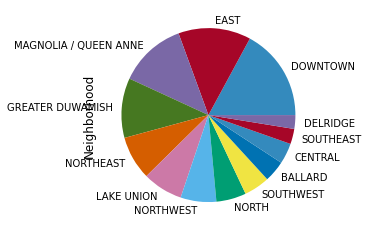

In [81]:
seattle['Neighborhood'].value_counts().plot.pie()

In [82]:
seattle['BuildingType'].value_counts()

NonResidential          1482
Multifamily LR (1-4)    1030
Multifamily MR (5-9)     584
Multifamily HR (10+)     110
SPS-District K-12         89
Nonresidential COS        85
Campus                    23
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [83]:
def BuildingType(value):
    if 'Nonresidential'.upper() in value.upper().strip():
        return 'NonResidential'.upper()
    elif 'Multifamily'.upper() in value.upper().strip():
        return 'Residential'.upper()    
    elif (('SPS-DISTRICT K-12'.upper() in value.upper().strip()) | ('CAMPUS'.upper() in value.upper().strip())):
        return 'School'.upper()    
    else:
        return value.strip().upper()
seattle['BuildingType']=seattle['BuildingType'].apply(BuildingType)    
seattle['BuildingType'].value_counts()

RESIDENTIAL       1724
NONRESIDENTIAL    1568
SCHOOL             112
Name: BuildingType, dtype: int64

<AxesSubplot:ylabel='BuildingType'>

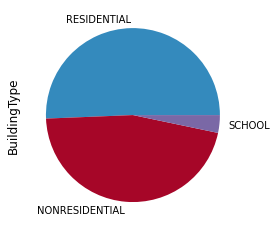

In [84]:
seattle['BuildingType'].value_counts().plot.pie()

In [85]:
seattle['PrimaryPropertyType'].value_counts()

Low-Rise Multifamily           1000
Mid-Rise Multifamily            568
Small- and Mid-Sized Office     299
Other                           260
Warehouse                       176
Large Office                    176
Mixed Use Property              131
K-12 School                     130
High-Rise Multifamily           105
Retail Store                     94
Hotel                            77
Worship Facility                 72
Distribution Center              53
Senior Care Community            45
Medical Office                   42
Supermarket / Grocery Store      38
Self-Storage Facility            23
Residence Hall                   23
University                       19
Non-Refrigerated Warehouse       12
Refrigerated Warehouse           12
Restaurant                       12
Laboratory                       10
Hospital                         10
Self-Storage Facility\n           5
College/University                5
Office                            3
SPS-District K-12           

In [86]:
#nous pourrons prendre pour plus tard d autres categorie en fonction de nos resultats futur
dictionnary = {  
                'Residential' : ['Low-Rise Multifamily','Mid-Rise Multifamily','High-Rise Multifamily'],
                 'Supermarket' : ['Supermarket / Grocery Store', 'Supermarket/Grocery Store'],
                 'Office':['Small- and Mid-Sized Office','Large Office','Office'],
                 'Other':['Other','Low-Rise Multifamily'],
                 'Entrepot':['Warehouse','Non-Refrigerated Warehouse', 'Refrigerated Warehouse', 'Self-Storage Facility', 'Self-Storage Facility\n'],
                 'School':['K-12 School','SPS-District K-12','University','College/University'],
                 'Other':['Other'], 
                 'Distribution Center':['Distribution Center','Distribution Center\n'],
                 'Restaurant':['Restaurant','Restaurant\n'],    
                 'Hotel' :['Hotel','Residence Hall','Residence Hall/Dormitory'],
                 'Medical' :['Hospital','Laboratory', 'Senior Care Community','Medical Office']
}

def renamePrimaryPropertyType(value): 
    result=''
    for key in dictionnary:        
        for val in dictionnary[key]:
            if(val == value):                              
                value = key
    return value
        
seattle['PrimaryPropertyType']=seattle['PrimaryPropertyType'].apply(renamePrimaryPropertyType)   

seattle['PrimaryPropertyType'].value_counts()

Residential            1673
Office                  478
Other                   260
Entrepot                228
School                  155
Mixed Use Property      131
Medical                 107
Hotel                   100
Retail Store             94
Worship Facility         72
Distribution Center      54
Supermarket              39
Restaurant               13
Name: PrimaryPropertyType, dtype: int64

<AxesSubplot:ylabel='PrimaryPropertyType'>

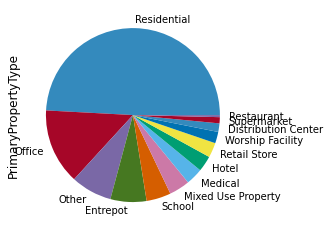

In [87]:
seattle['PrimaryPropertyType'].value_counts().plot.pie()

On peut se poser la question en regardant les categories ci dessous , si il ne faudrait pas supprimer les batiments correspondants aux habitations comme les maisons de retraites , Senior Care Community  Residence Hall/Dormitory , Residential Care Facility 

Nous allons regrouper la categories other

In [88]:
def other(value):
    if (pd.isnull(value)):
        return 'Other'
    elif ('Other' in value):    
        return 'Other'
    else:
        return value
seattle['LargestPropertyUseType'] = seattle['LargestPropertyUseType'].apply(other)    

la production totale doit être superieure à la somme des productions des bâtiments + des parkings :

**------------------------------------------------------------------------------------------------**

In [89]:
seattle.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'DefaultData',
       'ComplianceStatus', 'ZipCode', 'Latitude', 'Longitude', 'Address',
       'City', 'State'],
      dtype='object')

# nous allons avoir besoin de poser quelques hypothèses :

- la première, **l'hypothèse de linéarité**, est que nous pouvons approximer, pour chacun des points de notre jeu de données, son étiquette par une combinaison linéaire de la valeur des variables qui le décrivent : y(i)=β0+∑pj=1βjx(i)j+ϵi. Le terme de bruit  ϵi représente la différence entre la combinaison linéaire des variables et la vraie étiquette.

- la deuxième, **l'hypothèse de normalité**, est que le bruit est gaussien, ou normalement distribué : les ϵi sont la réalisation d'une variable aléatoire gaussienne, centrée en 0 et d'écart-type σ:  ϵ∼N(0,σ2). 

- la troisième, **l'hypothèse d'indépendance**, est que les n couples (x(i),y(i)) sont des réalisations indépendantes les unes des autres des variables x et y.

 la régression linéaire souffre de quelques inconvénients quand **les variables sont corrélées** : la solution n'est pas unique et les coefficients ont une grande variabilité, et l'interprétation est plus difficile, nous allons donc verifier la correlation de nos variables

<a name='cor'></a>
# Corrélation des variables

<AxesSubplot:title={'center':'Analyse des corrélations linéaires'}>

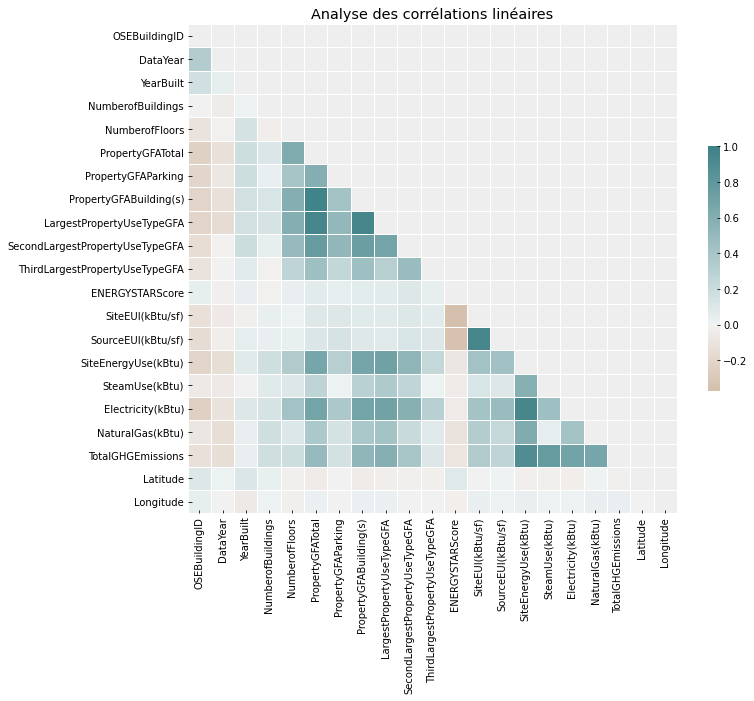

In [90]:
corr = seattle[seattle.columns].corr()
mask = np.triu(np.ones_like(corr,dtype=bool))
# set matplolib
f,ax = plt.subplots(figsize=(11,9))
cmap=sns.diverging_palette(400,200,as_cmap=True)
ax.set_title("Analyse des corrélations linéaires")
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=1, center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})

On remarque que nos variables cibles <code>SiteEnergyUse(kBtu)</code> et <code>TotalGHGEmissions</code> on des correlations presque similaire avec la consomations et les types de batiments

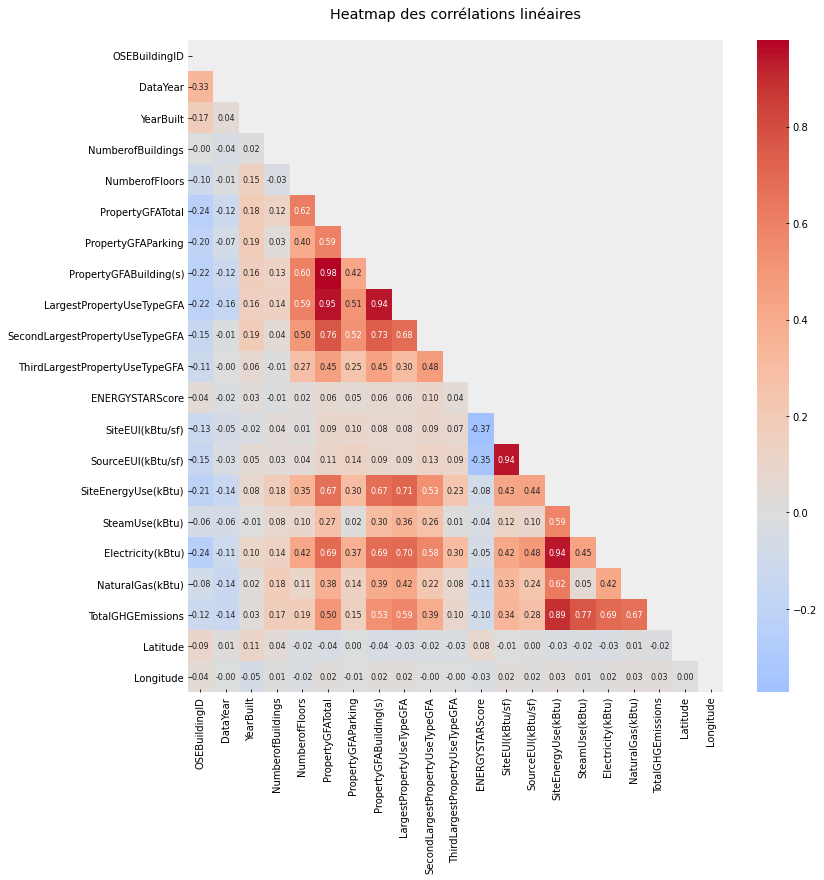

In [91]:
corr = seattle.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

On remarque sur ce Heatmap des corrélations linéaires entre variables.
Ces corrélations peuvent causer des problèmes de colinéarité dans nos futurs modèles. Isolons donc les paires de variables avec des corrélations de Pearson supérieurs à 0.7

In [92]:
# quantitativescol = sorted(list(seattle.select_dtypes(include=['float']).columns))
# echantillon = seattle[~seattle.isin([np.nan, np.inf, -np.inf]).any(1)]
# echantillon = echantillon[quantitativescol]
# echantillon.corr('pearson') 

In [93]:
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > 0.7)]).reset_index().rename(columns={0:'coefficient_correllation'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('coefficient_correllation', ascending=False)

,level_0,level_1,coefficient_correllation
20,PropertyGFATotal,PropertyGFABuilding(s),0.979556
18,LargestPropertyUseTypeGFA,PropertyGFATotal,0.949722
16,SourceEUI(kBtu/sf),SiteEUI(kBtu/sf),0.944884
14,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),0.944170
12,SiteEnergyUse(kBtu),Electricity(kBtu),0.938137
10,TotalGHGEmissions,SiteEnergyUse(kBtu),0.893009
8,SteamUse(kBtu),TotalGHGEmissions,0.766023
6,SecondLargestPropertyUseTypeGFA,PropertyGFATotal,0.764487
4,SecondLargestPropertyUseTypeGFA,PropertyGFABuilding(s),0.732308
2,LargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),0.710694


* La consommation totale d'énergie <code>PropertyGFATotal</code> est fortement corrélée à la surface des bâtiments <code>PropertyGFABuilding(s)</code>
* Les émissions de Co2 <code>TotalGHGEmissions</code> sont fortement corrélées à la consommation totale d'énergie <code>SiteEnergyUse(kBtu)</code>
* Les features 'LargestPropertyUseTypeGFA' et 'PropertyGFATotal' sont fortement corrrélées avec 'PropertyGFABuilding(s)' donc supprimées pour éviter la redondance d'informations

In [94]:
(seattle.isna().sum()/seattle.shape[0]).sort_values(ascending=True)

OSEBuildingID                      0.000000
Address                            0.000000
Longitude                          0.000000
Latitude                           0.000000
ZipCode                            0.000000
ComplianceStatus                   0.000000
DefaultData                        0.000000
TotalGHGEmissions                  0.000000
NaturalGas(kBtu)                   0.000000
Electricity(kBtu)                  0.000000
SteamUse(kBtu)                     0.000000
SiteEnergyUse(kBtu)                0.000000
SourceEUI(kBtu/sf)                 0.000000
SiteEUI(kBtu/sf)                   0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
City                               0.000000
ThirdLargestPropertyUseType        0.000000
SecondLargestPropertyUseType       0.000000
DataYear                           0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
CouncilDistrictCode                0.000000
Neighborhood                    

In [95]:
seattle['PropertyGFATotal'] = seattle['PropertyGFATotal'].astype('float')

In [96]:
seattle['BuildingAge'] = seattle['DataYear'] - seattle['YearBuilt']
seattle.drop('YearBuilt', axis=1, inplace=True)

In [97]:
seattle.shape

(3404, 35)

In [98]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
class RatioCalculator():
    def __init__(self, func,columns,additionnal_param):
        self.func = func
        self.columns = columns
        self.additionnal_param = additionnal_param

    def transform(self, input_df):
        return self.func(input_df,self.columns,self.additionnal_param)

        
    def fit(self, X, y=None):
        return self
    
# returns a the ratio between two columns
def process_ratio(input_df,columns,target):
    print(columns,target)
    input_df[target]=input_df[columns[0]].fillna(0) / input_df[columns[1]].fillna(0)        
    if(np.where((input_df[target] == np.inf))):
        input_df[target].replace([np.inf, -np.inf], np.nan, inplace=True)        
    return input_df    
    
    


pipe = Pipeline([
    ('selector', RatioCalculator(process_ratio,["Electricity(kBtu)",'SiteEnergyUse(kBtu)'],'Electricity')),
    ('selector1', RatioCalculator(process_ratio,["NaturalGas(kBtu)",'SiteEnergyUse(kBtu)'],'NaturalGas')),
    ('selector2', RatioCalculator(process_ratio,["SteamUse(kBtu)",'SiteEnergyUse(kBtu)'],'SteamUse')),
    ('selector3', RatioCalculator(process_ratio,["PropertyGFATotal",'NumberofBuildings'],'GFAPerBuilding')),
    ('selector4', RatioCalculator(process_ratio,["PropertyGFATotal",'NumberofFloors'],'GFAPerFloor')),
    ('selector5', RatioCalculator(process_ratio,["PropertyGFABuilding(s)",'PropertyGFATotal'],'GFABuildingRate')),
    ('selector6', RatioCalculator(process_ratio,["PropertyGFAParking",'PropertyGFATotal'],'GFAParkingRate')),        
])
# pd.DataFrame(seattle['BuildingType'])
seattle = pipe.fit_transform(seattle)

['Electricity(kBtu)', 'SiteEnergyUse(kBtu)'] Electricity
['NaturalGas(kBtu)', 'SiteEnergyUse(kBtu)'] NaturalGas
['SteamUse(kBtu)', 'SiteEnergyUse(kBtu)'] SteamUse
['PropertyGFATotal', 'NumberofBuildings'] GFAPerBuilding
['PropertyGFATotal', 'NumberofFloors'] GFAPerFloor
['PropertyGFABuilding(s)', 'PropertyGFATotal'] GFABuildingRate
['PropertyGFAParking', 'PropertyGFATotal'] GFAParkingRate


In [99]:
seattle.shape

(3404, 42)

In [100]:
seattle[['Electricity','NaturalGas','SteamUse','GFABuildingRate','GFAParkingRate','GFAPerBuilding','GFAPerFloor','NumberofFloors']].describe()

,Electricity,NaturalGas,SteamUse,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,NumberofFloors
count,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3.316000e+03,3.389000e+03,3389.000000
mean,0.732298,0.252807,0.012827,0.957642,0.042358,8.805148e+04,2.345215e+04,4.725583
std,0.272471,0.269889,0.074424,0.115863,0.115863,1.430610e+05,3.538307e+04,5.479133
min,0.000000,0.000000,0.000000,0.104977,0.000000,4.300000e+03,2.216970e+02,1.000000
25%,0.530103,0.000000,0.000000,1.000000,0.000000,2.779800e+04,8.636000e+03,2.000000
50%,0.775873,0.180931,0.000000,1.000000,0.000000,4.319150e+04,1.390600e+04,4.000000
75%,1.000000,0.451720,0.000000,1.000000,0.000000,8.719875e+04,2.612467e+04,5.000000
max,1.645032,1.000000,0.841591,1.000000,0.895023,2.200000e+06,1.100000e+06,99.000000


In [101]:

#supression des variables utiliser pour le calcul de ratio
tmp_EnergyUse = seattle["SiteEnergyUse(kBtu)"]
seattle.drop( list(seattle.filter(regex='(kBtu)')), axis=1, inplace=True) 
seattle["SiteEnergyUse(kBtu)"] = tmp_EnergyUse
seattle.drop([
              'LargestPropertyUseTypeGFA', 
              'SecondLargestPropertyUseTypeGFA',
              'SecondLargestPropertyUseType',\
              'ThirdLargestPropertyUseTypeGFA',
              'ThirdLargestPropertyUseType',
              'PropertyGFAParking',
              'PropertyGFABuilding(s)',
              'PropertyGFATotal'
],axis=1, inplace=True)



# seattle.drop(['PropertyGFATotal','LargestPropertyUseTypeGFA'],axis=1, inplace=True)


In [102]:
seattle[sorted(seattle.columns)].head()

,Address,BuildingAge,BuildingType,City,ComplianceStatus,CouncilDistrictCode,DataYear,DefaultData,ENERGYSTARScore,Electricity,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,LargestPropertyUseType,Latitude,ListOfAllPropertyUseTypes,Longitude,NaturalGas,Neighborhood,NumberofBuildings,NumberofFloors,OSEBuildingID,PrimaryPropertyType,SiteEnergyUse(kBtu),State,SteamUse,TotalGHGEmissions,ZipCode
0,405 Olive way,89.0,NONRESIDENTIAL,Seattle,Compliant,7,2016,False,60.0,0.546060,1.000000,0.000000,88434.0,7369.500000,Hotel,47.612200,Hotel,-122.337990,0.176638,DOWNTOWN,1.0,12.0,1,Hotel,7226362.5,WA,0.277302,249.98,98101
1,724 PINE ST,19.0,NONRESIDENTIAL,SEATTLE,Compliant,7,2015,No,51.0,0.467477,0.854547,0.145453,103566.0,9415.090909,Hotel,47.613106,"Hotel, Parking, Restaurant",-122.333358,0.532542,DOWNTOWN,1.0,11.0,2,Hotel,8354235.0,WA,0.000000,263.51,98101
2,1900 5TH AVE,46.0,NONRESIDENTIAL,SEATTLE,Compliant,7,2015,Yes,18.0,0.680459,1.000000,0.000000,961990.0,23463.170732,Hotel,47.613349,"Hotel, Parking, Swimming Pool",-122.337699,0.050730,DOWNTOWN,1.0,41.0,3,Hotel,73130656.0,WA,0.268839,2061.48,98101
3,620 STEWART ST,89.0,NONRESIDENTIAL,SEATTLE,Compliant,7,2015,No,1.0,0.098090,1.000000,0.000000,61320.0,6132.000000,Hotel,47.614216,Hotel,-122.336609,0.070915,DOWNTOWN,1.0,10.0,5,Hotel,28229320.0,WA,0.830998,1936.34,98101
4,401 LENORA ST,35.0,NONRESIDENTIAL,SEATTLE,Compliant,7,2015,No,67.0,0.409077,0.896071,0.103929,119890.0,6660.555556,Hotel,47.613754,"Hotel, Parking, Swimming Pool",-122.340924,0.590940,DOWNTOWN,1.0,18.0,8,Hotel,14829099.0,WA,0.000000,507.70,98121


In [103]:
(seattle.isna().sum()/seattle.shape[0]).sort_values(ascending=True)

OSEBuildingID                0.000000
GFABuildingRate              0.000000
SteamUse                     0.000000
NaturalGas                   0.000000
Electricity                  0.000000
State                        0.000000
City                         0.000000
Address                      0.000000
Longitude                    0.000000
Latitude                     0.000000
GFAParkingRate               0.000000
ComplianceStatus             0.000000
ZipCode                      0.000000
TotalGHGEmissions            0.000000
LargestPropertyUseType       0.000000
NumberofBuildings            0.000000
Neighborhood                 0.000000
CouncilDistrictCode          0.000000
PrimaryPropertyType          0.000000
BuildingType                 0.000000
DataYear                     0.000000
DefaultData                  0.000000
SiteEnergyUse(kBtu)          0.000000
NumberofFloors               0.004407
GFAPerFloor                  0.004407
ListOfAllPropertyUseTypes    0.006463
BuildingAge 

In [104]:
seattle[['Electricity', 'NaturalGas', 'SteamUse','GFAPerBuilding','GFAPerFloor','GFABuildingRate','GFAParkingRate']].describe()

,Electricity,NaturalGas,SteamUse,GFAPerBuilding,GFAPerFloor,GFABuildingRate,GFAParkingRate
count,3404.000000,3404.000000,3404.000000,3.316000e+03,3.389000e+03,3404.000000,3404.000000
mean,0.732298,0.252807,0.012827,8.805148e+04,2.345215e+04,0.957642,0.042358
std,0.272471,0.269889,0.074424,1.430610e+05,3.538307e+04,0.115863,0.115863
min,0.000000,0.000000,0.000000,4.300000e+03,2.216970e+02,0.104977,0.000000
25%,0.530103,0.000000,0.000000,2.779800e+04,8.636000e+03,1.000000,0.000000
50%,0.775873,0.180931,0.000000,4.319150e+04,1.390600e+04,1.000000,0.000000
75%,1.000000,0.451720,0.000000,8.719875e+04,2.612467e+04,1.000000,0.000000
max,1.645032,1.000000,0.841591,2.200000e+06,1.100000e+06,1.000000,0.895023


In [105]:
# seattle = seattle[~ (seattle['YearBuilt'].isna() ) & ~(seattle['NumberofFloors'].isna())& ~(seattle['ListOfAllPropertyUseTypes'].isna())]

In [106]:
seuil = 0.7
corr = seattle.corr()
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > seuil)]).reset_index().rename(columns={0:'coefficient_correllation'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('coefficient_correllation', ascending=False)

,level_0,level_1,coefficient_correllation
4,SiteEnergyUse(kBtu),TotalGHGEmissions,0.893009
2,NaturalGas,Electricity,-0.952077
0,GFAParkingRate,GFABuildingRate,-1.000000


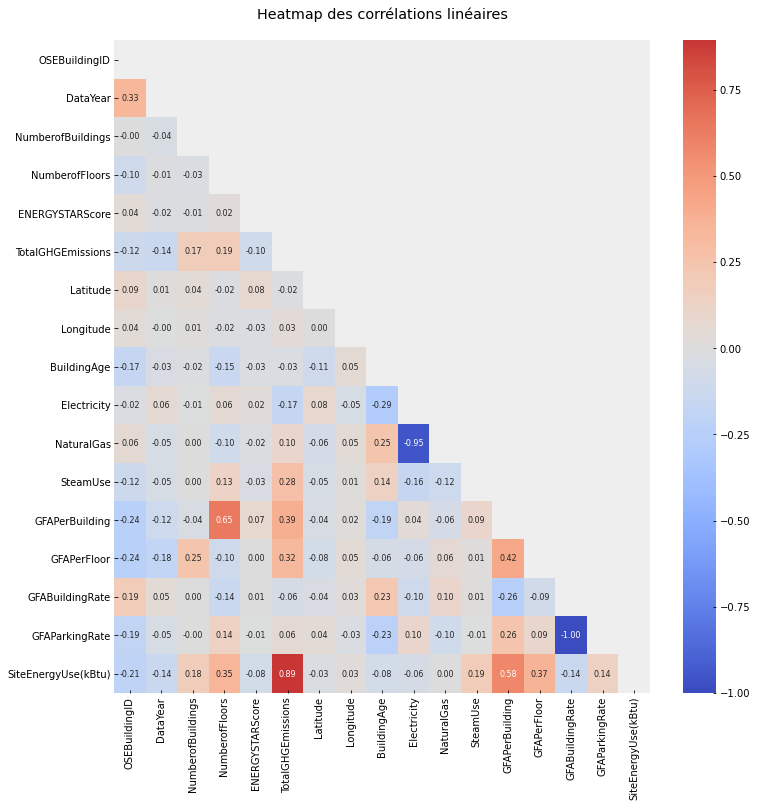

In [107]:
corr = seattle.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

In [108]:
seuil = 0.7
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > seuil)]).reset_index().rename(columns={0:'coefficient_correllation'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('coefficient_correllation', ascending=False)

,level_0,level_1,coefficient_correllation
4,SiteEnergyUse(kBtu),TotalGHGEmissions,0.893009
2,NaturalGas,Electricity,-0.952077
0,GFAParkingRate,GFABuildingRate,-1.000000


In [109]:
quantitativescol = sorted(list(seattle.select_dtypes(include=['float']).columns))
echantillon = seattle[~seattle.isin([np.nan, np.inf, -np.inf]).any(1)]
echantillon = echantillon[quantitativescol]
echantillon.corr('pearson') 

,BuildingAge,ENERGYSTARScore,Electricity,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,Latitude,Longitude,NaturalGas,NumberofBuildings,NumberofFloors,SiteEnergyUse(kBtu),SteamUse,TotalGHGEmissions
BuildingAge,1.000000,-0.028206,-0.333368,0.226630,-0.226630,-0.199939,-0.084549,-0.095153,0.069924,0.292917,-0.026626,-0.137963,-0.067360,0.162105,-0.013697
ENERGYSTARScore,-0.028206,1.000000,0.021983,0.005938,-0.005938,0.076591,0.019815,0.082702,-0.024371,-0.015005,-0.005299,0.024817,-0.075530,-0.036176,-0.091286
Electricity,-0.333368,0.021983,1.000000,-0.107478,0.107478,0.040535,-0.076234,0.101419,-0.053196,-0.961600,0.017551,0.051478,-0.054414,-0.156279,-0.158244
GFABuildingRate,0.226630,0.005938,-0.107478,1.000000,-1.000000,-0.275690,-0.089911,-0.013907,0.036320,0.110910,0.016437,-0.159765,-0.113964,-0.002985,-0.037019
GFAParkingRate,-0.226630,-0.005938,0.107478,-1.000000,1.000000,0.275690,0.089911,0.013907,-0.036320,-0.110910,-0.016437,0.159765,0.113964,0.002985,0.037019
GFAPerBuilding,-0.199939,0.076591,0.040535,-0.275690,0.275690,1.000000,0.308794,-0.062598,0.012522,-0.069520,-0.038301,0.715601,0.574955,0.104043,0.368397
GFAPerFloor,-0.084549,0.019815,-0.076234,-0.089911,0.089911,0.308794,1.000000,-0.091772,0.060538,0.075462,0.121267,-0.111239,0.283102,-0.001467,0.265531
Latitude,-0.095153,0.082702,0.101419,-0.013907,0.013907,-0.062598,-0.091772,1.000000,-0.002822,-0.086833,0.065886,-0.044244,-0.028437,-0.048864,-0.018461
Longitude,0.069924,-0.024371,-0.053196,0.036320,-0.036320,0.012522,0.060538,-0.002822,1.000000,0.050189,0.013686,-0.017959,0.030952,0.011674,0.038005
NaturalGas,0.292917,-0.015005,-0.961600,0.110910,-0.110910,-0.069520,0.075462,-0.086833,0.050189,1.000000,-0.023198,-0.088819,-0.002957,-0.099571,0.081749


In [110]:
quantitativescol = sorted(list(seattle.select_dtypes(include=['float']).columns))
echantillon = seattle[~seattle.isin([np.nan, np.inf, -np.inf]).any(1)]
echantillon = echantillon[quantitativescol]
echantillon.corr('spearman') 

,BuildingAge,ENERGYSTARScore,Electricity,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,Latitude,Longitude,NaturalGas,NumberofBuildings,NumberofFloors,SiteEnergyUse(kBtu),SteamUse,TotalGHGEmissions
BuildingAge,1.000000,-0.062826,-0.230934,0.242862,-0.242862,-0.339256,-0.164323,-0.109677,0.081709,0.194483,-0.040477,-0.288551,-0.188378,0.143324,-0.021494
ENERGYSTARScore,-0.062826,1.000000,0.003355,-0.001080,0.001080,0.080812,0.015568,0.076325,-0.043550,0.002083,0.011510,0.111194,-0.166980,-0.017523,-0.104793
Electricity,-0.230934,0.003355,1.000000,-0.066988,0.066988,-0.064447,-0.133920,0.108503,-0.052210,-0.938711,0.001844,0.086311,-0.330617,-0.133367,-0.699855
GFABuildingRate,0.242862,-0.001080,-0.066988,1.000000,-1.000000,-0.338509,-0.183918,0.004786,0.065799,0.081715,0.005556,-0.261254,-0.310968,-0.063743,-0.201652
GFAParkingRate,-0.242862,0.001080,0.066988,-1.000000,1.000000,0.338509,0.183918,-0.004786,-0.065799,-0.081715,-0.005556,0.261254,0.310968,0.063743,0.201652
GFAPerBuilding,-0.339256,0.080812,-0.064447,-0.338509,0.338509,1.000000,0.610882,-0.100743,-0.030858,0.037248,-0.129957,0.470975,0.791969,0.169709,0.599892
GFAPerFloor,-0.164323,0.015568,-0.133920,-0.183918,0.183918,0.610882,1.000000,-0.128441,0.064956,0.139007,0.042760,-0.306945,0.539753,0.011176,0.444774
Latitude,-0.109677,0.076325,0.108503,0.004786,-0.004786,-0.100743,-0.128441,1.000000,-0.021179,-0.086208,0.055445,0.020793,-0.122752,-0.118023,-0.145668
Longitude,0.081709,-0.043550,-0.052210,0.065799,-0.065799,-0.030858,0.064956,-0.021179,1.000000,0.051429,0.039060,-0.124085,0.013386,-0.010479,0.023968
NaturalGas,0.194483,0.002083,-0.938711,0.081715,-0.081715,0.037248,0.139007,-0.086208,0.051429,1.000000,0.003313,-0.123131,0.296352,-0.079897,0.671637


# ACP

In [111]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from functions import *

quantitativescol = sorted(list(seattle.select_dtypes(include=['float', 'int']).columns))
# cols = ['TotalGHGEmissions','SiteEnergyUse(kBtu)','YearBuilt','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuilding(s)']

echantillon = seattle[~seattle.isin([np.nan, np.inf, -np.inf]).any(1)]
n_comp = 6
acp_vars = echantillon[quantitativescol]
acp_vars = acp_vars.dropna()
# keep_ind = X.index
X = acp_vars.values
X.shape
# X

(2360, 17)

In [112]:
#on sauvegarde donc les intutules des colonnes dans les variables names et features

features = acp_vars.columns

# #centrage et reduction
X_scaled = preprocessing.StandardScaler().fit_transform(X)

In [113]:
# calcul des composantes principales
pca = decomposition.PCA(n_components=14)
pca.fit(X_scaled)

PCA(n_components=14)

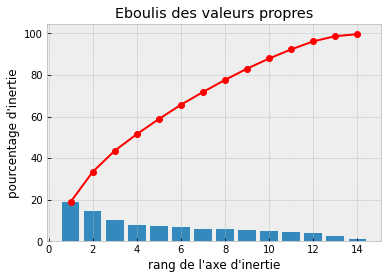

In [114]:
display_scree_plot(pca)

In [115]:
pcs = pca.components_

**On voit clairement une correllation entre nos deux variables cibles <code>TotalGHGEmissions</code> et <code>SiteEnergyUse(kBtu)</code>**

<Figure size 1440x1440 with 0 Axes>

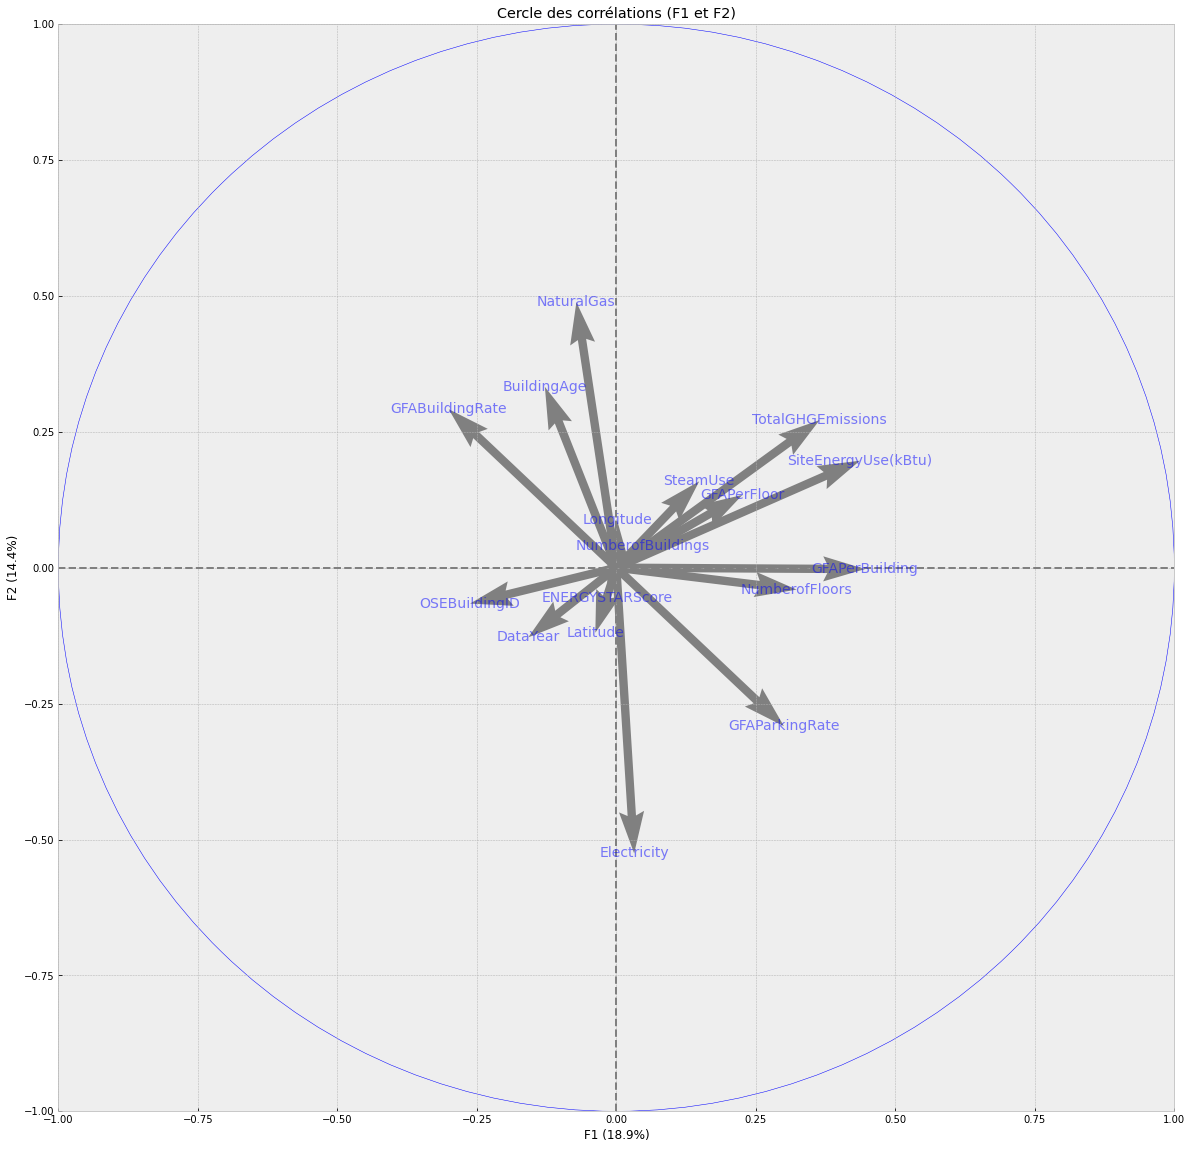

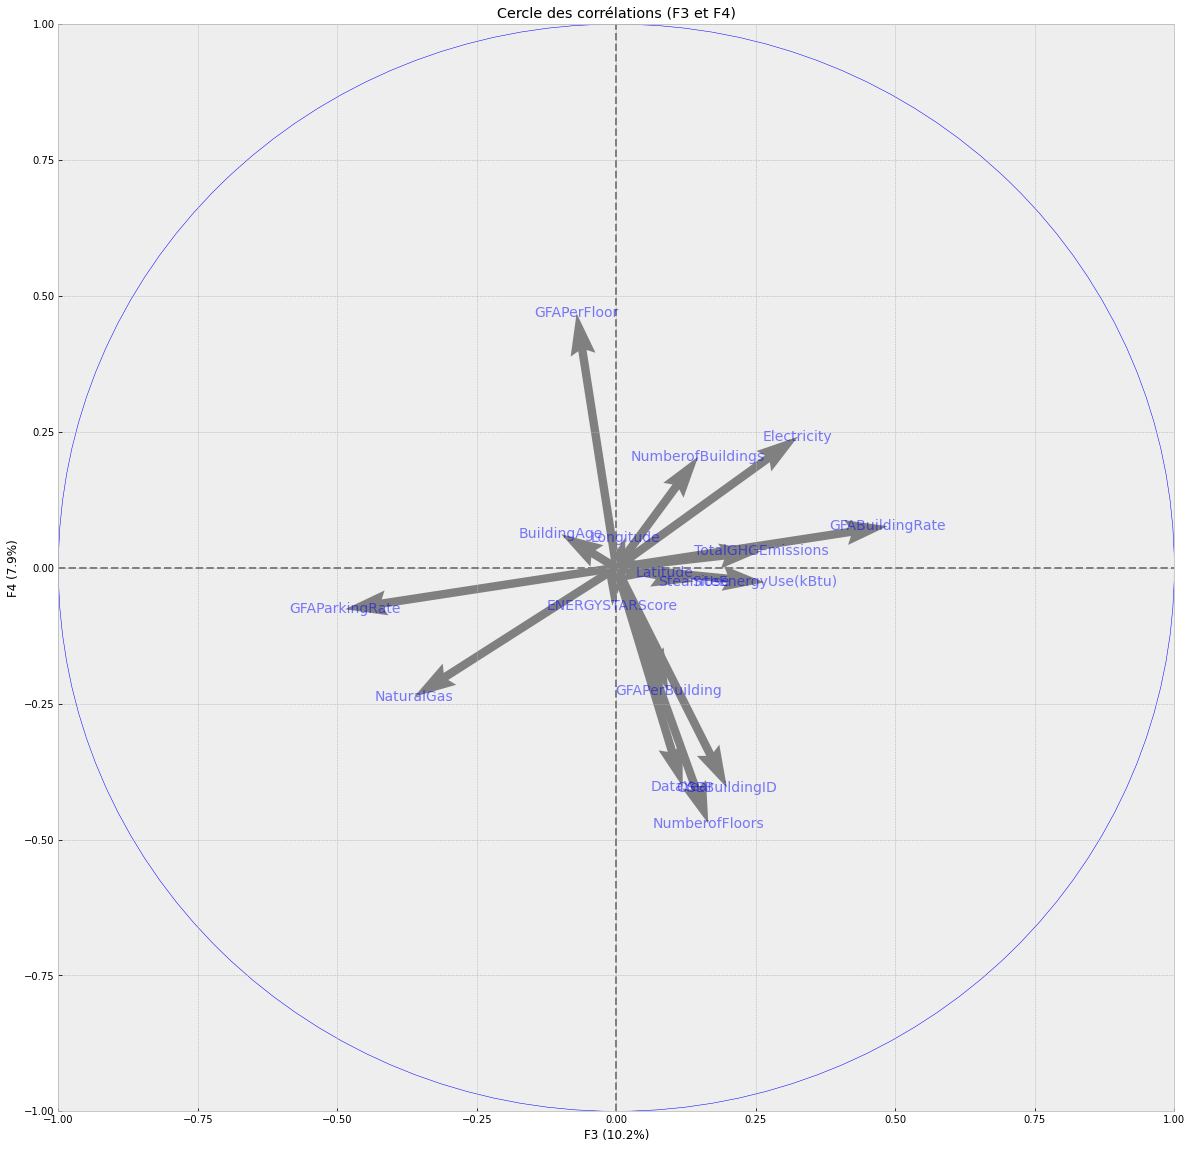

In [116]:
fig = plt.figure(figsize=(20,20))
display_circles(pcs,5,pca,[(0,1),(2,3),(4,5)],labels=np.array(features))

In [117]:
seattle.columns[seattle.isna().any()].tolist()

['NumberofFloors',
 'ListOfAllPropertyUseTypes',
 'ENERGYSTARScore',
 'BuildingAge',
 'GFAPerBuilding',
 'GFAPerFloor']

filtre des dernieres valeurs manquqntes

In [118]:
(seattle.isna().sum()/seattle.shape[0]).sort_values(ascending=True)

OSEBuildingID                0.000000
GFABuildingRate              0.000000
SteamUse                     0.000000
NaturalGas                   0.000000
Electricity                  0.000000
State                        0.000000
City                         0.000000
Address                      0.000000
Longitude                    0.000000
Latitude                     0.000000
GFAParkingRate               0.000000
ComplianceStatus             0.000000
ZipCode                      0.000000
TotalGHGEmissions            0.000000
LargestPropertyUseType       0.000000
NumberofBuildings            0.000000
Neighborhood                 0.000000
CouncilDistrictCode          0.000000
PrimaryPropertyType          0.000000
BuildingType                 0.000000
DataYear                     0.000000
DefaultData                  0.000000
SiteEnergyUse(kBtu)          0.000000
NumberofFloors               0.004407
GFAPerFloor                  0.004407
ListOfAllPropertyUseTypes    0.006463
BuildingAge 

In [119]:
seattle.describe()

,OSEBuildingID,DataYear,NumberofBuildings,NumberofFloors,ENERGYSTARScore,TotalGHGEmissions,Latitude,Longitude,BuildingAge,Electricity,NaturalGas,SteamUse,GFAPerBuilding,GFAPerFloor,GFABuildingRate,GFAParkingRate,SiteEnergyUse(kBtu)
count,3404.000000,3404.000000,3404.000000,3389.000000,2464.000000,3404.000000,3404.000000,3404.000000,3348.000000,3404.000000,3404.000000,3404.000000,3.316000e+03,3.389000e+03,3404.000000,3404.000000,3.404000e+03
mean,21204.278790,2015.938895,1.064924,4.725583,66.567370,113.075220,47.624095,-122.334816,46.426523,0.732298,0.252807,0.012827,8.805148e+04,2.345215e+04,0.957642,0.042358,5.070936e+06
std,12168.812188,0.239557,0.807810,5.479133,26.516688,420.693874,0.047776,0.027110,32.265429,0.272471,0.269889,0.074424,1.430610e+05,3.538307e+04,0.115863,0.115863,1.381347e+07
min,1.000000,2015.000000,0.000000,1.000000,1.000000,0.090000,47.499170,-122.414250,1.000000,0.000000,0.000000,0.000000,4.300000e+03,2.216970e+02,0.104977,0.000000,1.340900e+04
25%,19998.000000,2016.000000,1.000000,2.000000,51.000000,9.480000,47.599868,-122.350445,19.000000,0.530103,0.000000,0.000000,2.779800e+04,8.636000e+03,1.000000,0.000000,9.355344e+05
50%,23112.000000,2016.000000,1.000000,4.000000,73.000000,33.920000,47.618665,-122.332610,40.000000,0.775873,0.180931,0.000000,4.319150e+04,1.390600e+04,1.000000,0.000000,1.807103e+06
75%,25992.500000,2016.000000,1.000000,5.000000,88.000000,94.070000,47.657157,-122.319564,66.000000,1.000000,0.451720,0.000000,8.719875e+04,2.612467e+04,1.000000,0.000000,4.226081e+06
max,50226.000000,2016.000000,23.000000,99.000000,99.000000,12307.160000,47.733870,-122.220966,115.000000,1.645032,1.000000,0.841591,2.200000e+06,1.100000e+06,1.000000,0.895023,2.958126e+08


<a name="nov"></a>
#  Test de normalité Kolmogorov Smirnov

**Le test de normalité Kolmogorov Smirnov nous indique que les distributions ne sont pas normal**

In [120]:
from scipy import stats

quantitativescol = sorted(list(seattle.select_dtypes(include=['float']).columns))

numeric_columns = seattle[quantitativescol]
numeric_columns = numeric_columns[1:]

for column in numeric_columns:
    print('________\n{}'.format(column))
    D, p = stats.kstest(seattle[column].dropna(), 
                     'norm', 
                     args=(seattle[column].mean(), seattle[column].std()))
    alpha = 5e-2
    print("p = {}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected : {} is not from a normal distribution".format(column))
    else:
        print("The null hypothesis cannot be rejected")

________
BuildingAge
p = 9.356571016200595e-30
The null hypothesis can be rejected : BuildingAge is not from a normal distribution
________
ENERGYSTARScore
p = 4.6762390341089524e-29
The null hypothesis can be rejected : ENERGYSTARScore is not from a normal distribution
________
Electricity
p = 1.6246261386367917e-117
The null hypothesis can be rejected : Electricity is not from a normal distribution
________
GFABuildingRate
p = 0.0
The null hypothesis can be rejected : GFABuildingRate is not from a normal distribution
________
GFAParkingRate
p = 0.0
The null hypothesis can be rejected : GFAParkingRate is not from a normal distribution
________
GFAPerBuilding
p = 2.26779777427712e-268
The null hypothesis can be rejected : GFAPerBuilding is not from a normal distribution
________
GFAPerFloor
p = 1.9444516849521085e-247
The null hypothesis can be rejected : GFAPerFloor is not from a normal distribution
________
Latitude
p = 1.8772442190184932e-30
The null hypothesis can be rejected : Lat

In [121]:
seattle.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings',
       'NumberofFloors', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'ENERGYSTARScore', 'TotalGHGEmissions', 'DefaultData',
       'ComplianceStatus', 'ZipCode', 'Latitude', 'Longitude', 'Address',
       'City', 'State', 'BuildingAge', 'Electricity', 'NaturalGas', 'SteamUse',
       'GFAPerBuilding', 'GFAPerFloor', 'GFABuildingRate', 'GFAParkingRate',
       'SiteEnergyUse(kBtu)'],
      dtype='object')

Les résultats des tests de Kolmogorov-Smirnov (Pvalue < au niveau de test de 5%) on rejette donc l'hypothèse de normalité des distributions de ces variables.

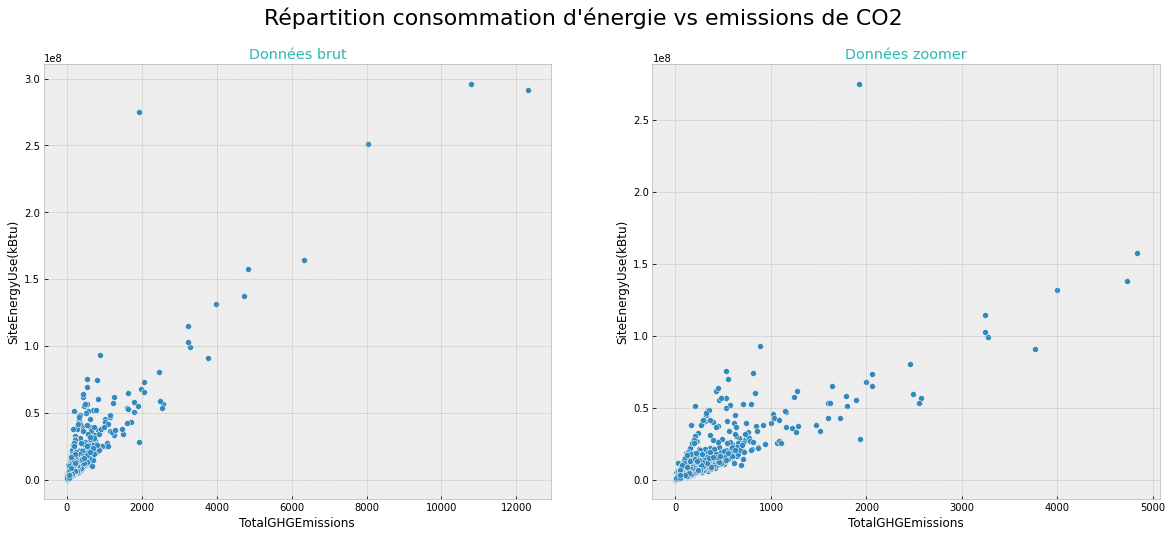

In [122]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.scatterplot(data=seattle, x="TotalGHGEmissions", y="SiteEnergyUse(kBtu)", ax=axes[0])
axes[0].set_title("Données brut", color='#2cb7b0')
sns.scatterplot(data=seattle[(seattle['TotalGHGEmissions'] < 5000)], x="TotalGHGEmissions", y="SiteEnergyUse(kBtu)", ax=axes[1])
axes[1].set_title("Données zoomer", color='#2cb7b0')
plt.suptitle("Répartition consommation d'énergie vs emissions de CO2", fontsize=22)
plt.show()

In [123]:
seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3404 entries, 0 to 3403
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              3404 non-null   int64  
 1   DataYear                   3404 non-null   int64  
 2   BuildingType               3404 non-null   object 
 3   PrimaryPropertyType        3404 non-null   object 
 4   CouncilDistrictCode        3404 non-null   object 
 5   Neighborhood               3404 non-null   object 
 6   NumberofBuildings          3404 non-null   float64
 7   NumberofFloors             3389 non-null   float64
 8   ListOfAllPropertyUseTypes  3382 non-null   object 
 9   LargestPropertyUseType     3404 non-null   object 
 10  ENERGYSTARScore            2464 non-null   float64
 11  TotalGHGEmissions          3404 non-null   float64
 12  DefaultData                3404 non-null   object 
 13  ComplianceStatus           3404 non-null   objec

In [124]:
seattle.shape

(3404, 29)

<a name="mul"></a>
# Analyse multivariee

In [125]:
 sorted(list(seattle.select_dtypes(include=['object']).columns))

['Address',
 'BuildingType',
 'City',
 'ComplianceStatus',
 'CouncilDistrictCode',
 'DefaultData',
 'LargestPropertyUseType',
 'ListOfAllPropertyUseTypes',
 'Neighborhood',
 'PrimaryPropertyType',
 'State',
 'ZipCode']

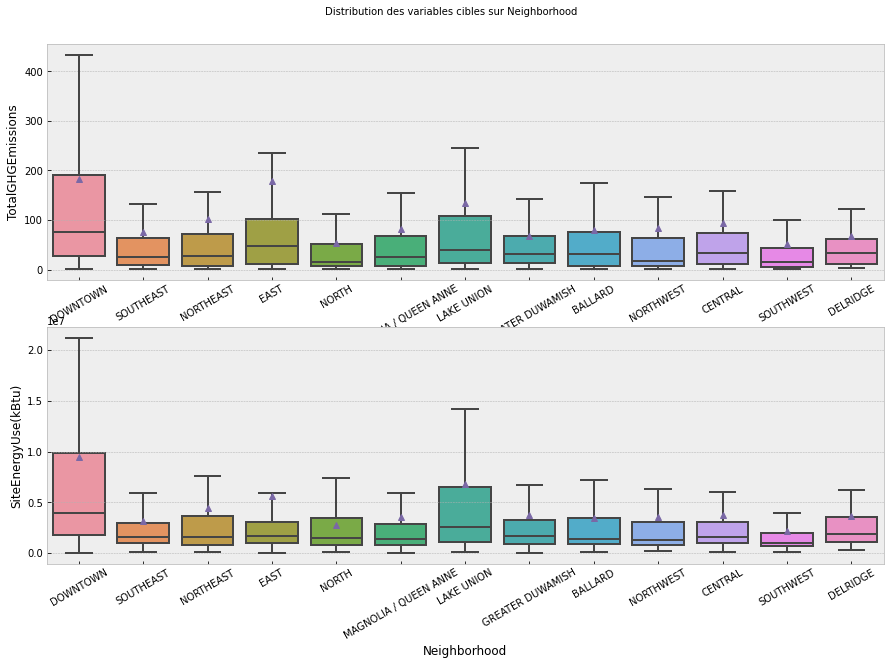

In [126]:
fig = plt.figure(figsize=(15,20))
columntocheck = [
'TotalGHGEmissions',
'SiteEnergyUse(kBtu)'
 ]
# fig=plt.figure(figsize=[18,25])
for i in range(len(columntocheck)):

    fig.add_subplot(4,1,i+1)
    col = columntocheck[i]
    ax = sns.boxplot(x="Neighborhood", y=col, data=seattle,showfliers=False,showmeans=True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

fig.text(0.5, 0.90, r"Distribution des variables cibles sur Neighborhood", ha="center")
plt.show()


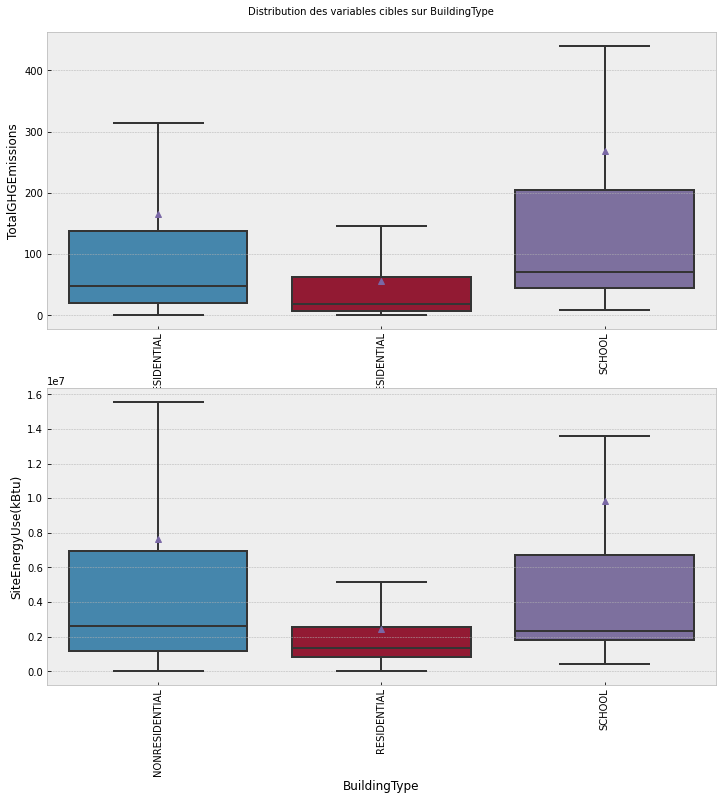

In [127]:

fig = plt.figure(figsize=(12,12))
columntocheck = [
'TotalGHGEmissions',
'SiteEnergyUse(kBtu)'
 ]
# fig=plt.figure(figsize=[18,25])
for i in range(len(columntocheck)):

    fig.add_subplot(2,1,i+1)
    col = columntocheck[i]
    ax = sns.boxplot(x="BuildingType", y=col, data=seattle,showfliers=False,showmeans=True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

fig.text(0.5, 0.90, r"Distribution des variables cibles sur BuildingType", ha="center")
plt.show()



Les ecoles sont de grands consommateur en CO2 et electricite

In [128]:
seattle.LargestPropertyUseType.value_counts().sort_index()

Adult Education                                            2
Automobile Dealership                                      6
Bank Branch                                                4
College/University                                        24
Courthouse                                                 1
Data Center                                                3
Distribution Center                                       54
Financial Office                                           4
Fire Station                                               1
Fitness Center/Health Club/Gym                             5
Food Service                                               1
Hospital (General Medical & Surgical)                     10
Hotel                                                     75
K-12 School                                              130
Laboratory                                                13
Library                                                    4
Lifestyle Center        

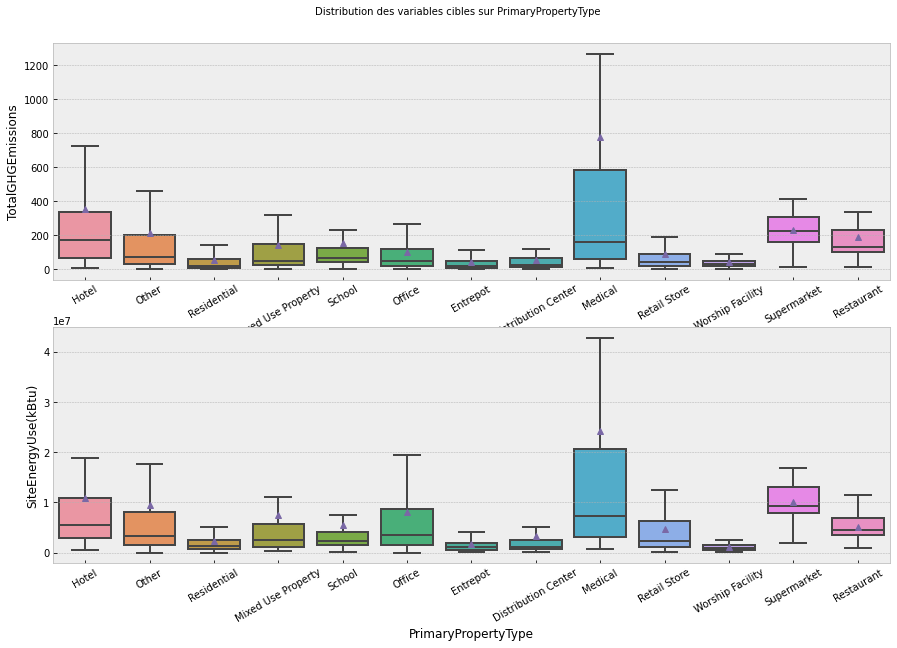

In [129]:
fig = plt.figure(figsize=(15,20))
columntocheck = [
'TotalGHGEmissions',
'SiteEnergyUse(kBtu)'
 ]
# fig=plt.figure(figsize=[18,25])
for i in range(len(columntocheck)):

    fig.add_subplot(4,1,i+1)
    col = columntocheck[i]
    ax = sns.boxplot(x="PrimaryPropertyType", y=col, data=seattle,showfliers=False,showmeans=True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

fig.text(0.5, 0.90, r"Distribution des variables cibles sur PrimaryPropertyType", ha="center")
plt.show()

Les centres mdedicaux sont de grands consommateur en CO2 et electricite

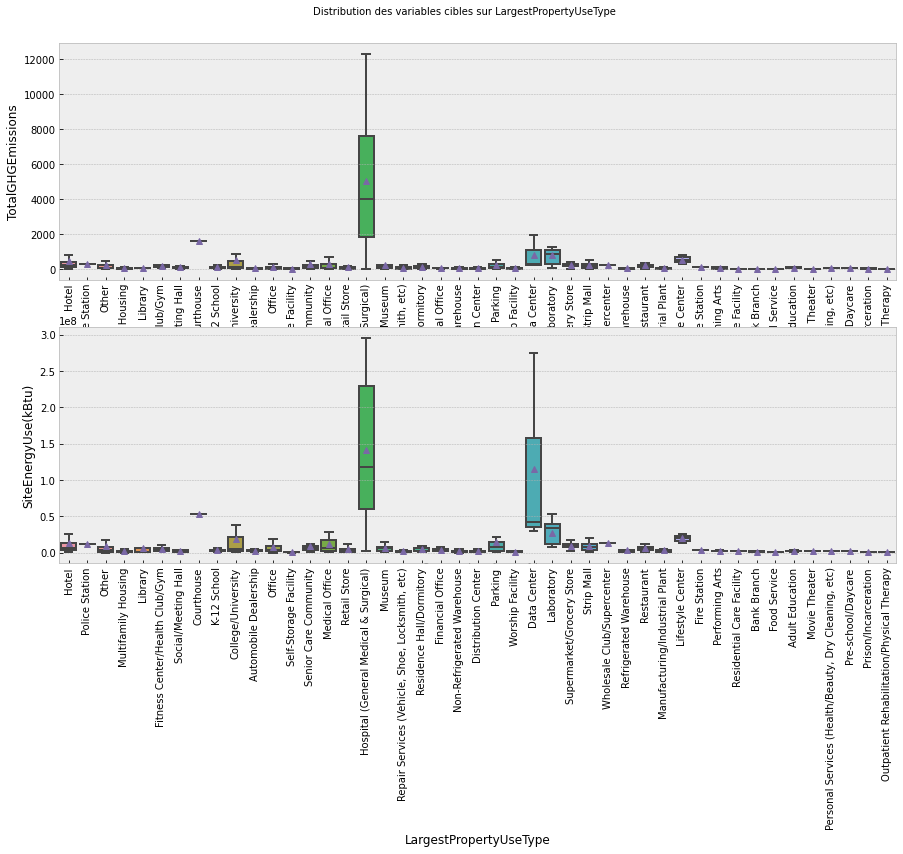

In [130]:
fig = plt.figure(figsize=(15,20))
columntocheck = [
'TotalGHGEmissions',
'SiteEnergyUse(kBtu)'
 ]
# fig=plt.figure(figsize=[18,25])
for i in range(len(columntocheck)):

    fig.add_subplot(4,1,i+1)
    col = columntocheck[i]
    ax = sns.boxplot(x="LargestPropertyUseType", y=col, data=seattle,showfliers=False,showmeans=True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

fig.text(0.5, 0.90, r"Distribution des variables cibles sur LargestPropertyUseType", ha="center")
plt.show()

<a id='lat'></a>
# Repartition des batiments par latitude longitude

In [131]:
import folium
import folium.plugins
seattle_lat = 47.6062
seattle_lon = -122.3321
echantillon = seattle
seattle_map = folium.Map(location=[seattle_lat,seattle_lon], zoom_start=11)
#Clusters
marker_cluster = folium.plugins.MarkerCluster().add_to(seattle_map)
for lat, lng, in zip(seattle.Latitude, seattle.Longitude):
    folium.Marker(location=[lat, lng]).add_to(marker_cluster)

seattle_map

# distribution de nos variables cibles

In [132]:
# Variables prédictives
y_labels = ["SiteEnergyUse(kBtu)","TotalGHGEmissions","Electricity","NaturalGas","SteamUse"]

# Variables catégorielles
cat_attribs = list(seattle.select_dtypes(include='object').columns)

# Variables numériques
num_attribs = list(seattle.drop(columns=cat_attribs + y_labels + ["ENERGYSTARScore"]).columns)

In [133]:
seattle.loc[:, ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]].describe()

,SiteEnergyUse(kBtu),TotalGHGEmissions
count,3.404000e+03,3404.000000
mean,5.070936e+06,113.075220
std,1.381347e+07,420.693874
min,1.340900e+04,0.090000
25%,9.355344e+05,9.480000
50%,1.807103e+06,33.920000
75%,4.226081e+06,94.070000
max,2.958126e+08,12307.160000


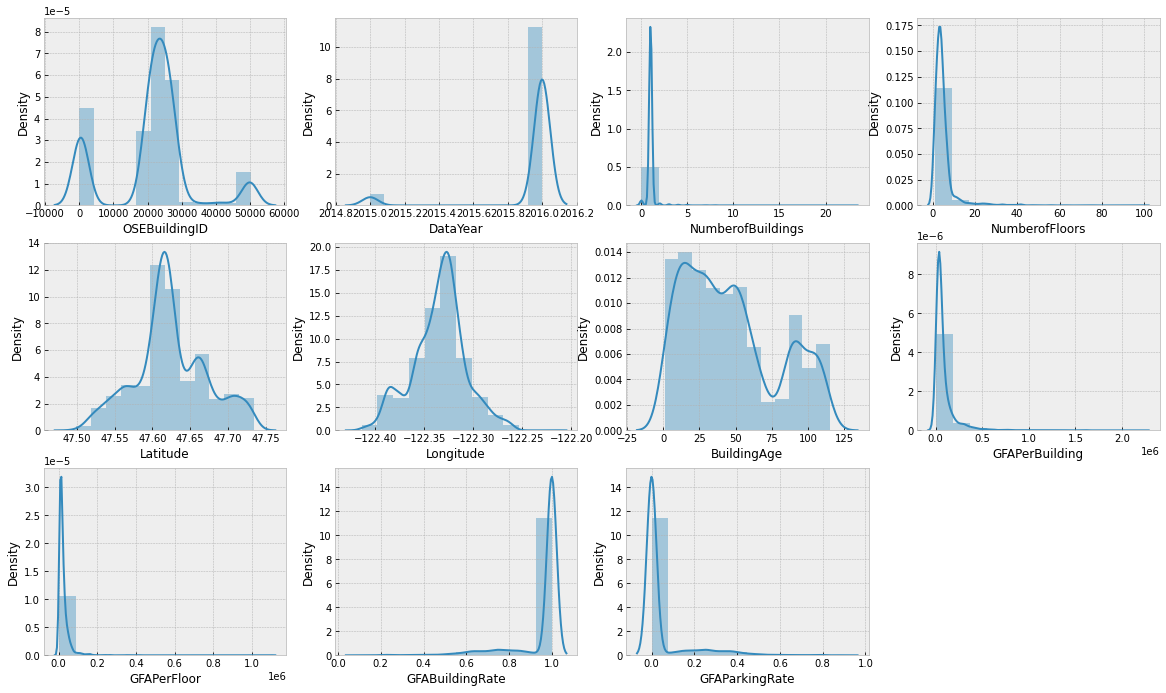

In [134]:
# seattle = seattle[~seattle.isin([np.nan, np.inf, -np.inf]).any(1)]
quantitativescol = sorted(list(seattle.select_dtypes(include=['float']).columns))
# num_attribs.remove("OSEBuildingID")
fig = plt.figure(1, figsize=(20, 20))
for i, label in enumerate(num_attribs) :
    plt.subplot(5, 4, i + 1)
    sns.distplot(seattle[label], bins=int(1 + np.log2(len(seattle))))
plt.show()

In [135]:
cat_attribs

['BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'DefaultData',
 'ComplianceStatus',
 'ZipCode',
 'Address',
 'City',
 'State']

**Observation des variables cibles  et avec transformations logarihtmique :**

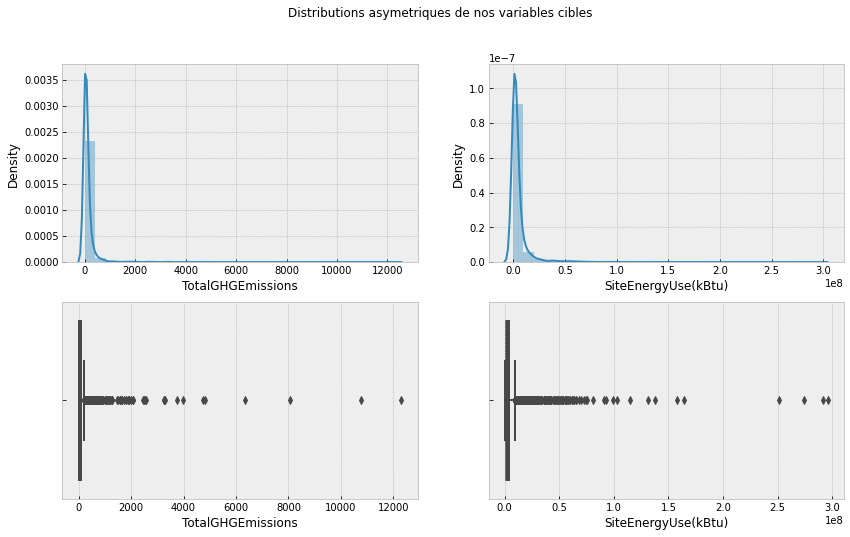

In [136]:
fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(seattle[label], bins=30)
    plt.subplot(2,2,i+3)
    sns.boxplot(seattle[label], orient="v")
plt.suptitle("Distributions asymetriques de nos variables cibles")      
plt.show()

Passage au log des variables cibles :

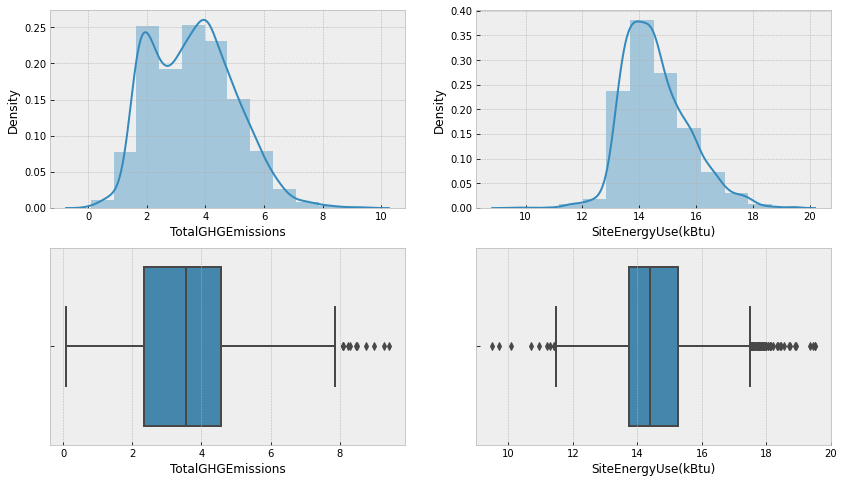

In [137]:
fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(seattle[label].apply(lambda x : np.log(1 + x)), bins=int(1 + np.log2(len(seattle))))
    plt.subplot(2,2,i+3)
    sns.boxplot(seattle[label].apply(lambda x : np.log(1 + x)), orient="v")
plt.show()

In [138]:
# seattle = seattletmp.copy()

**la méthode de Tukey peut être appliqué, car les distributions sont normales en passant par les logs**

La règle de Tukey, propose de retirer les valeurs comprises hors de l'intervalle :

[Q1 - 1.5 x IQR ; Q3 +1.5 x IQR]

Où Q1 et Q3 sont le premier et troisième quartile (25%, 75%) et où IQR (interquartile range) est égale à Q3 - Q1.

Appliquons les pour nos variables cibles

suppresion des outliers et passage au log pour reveler une distribution Gausian

In [139]:
Q1 = round(np.percentile(seattle["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x)), 25))
Q3 = round(np.percentile(seattle["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x)), 75))

born_sup_energy = Q3 + 1.5*(Q3-Q1)
born_inf_energy = Q1 - 1.5*(Q3-Q1)

seattle = seattle[(seattle["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x))<born_sup_energy) & (seattle["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x))>born_inf_energy)]

In [140]:
Q1 = round(np.percentile(seattle["TotalGHGEmissions"].apply(lambda x : np.log(1 + x)), 25))
Q3 = round(np.percentile(seattle["TotalGHGEmissions"].apply(lambda x : np.log(1 + x)), 75))

born_sup_co2 = Q3 + 1.5*(Q3-Q1)
born_inf_co2 = Q1 - 1.5*(Q3-Q1)

seattle = seattle[(seattle["TotalGHGEmissions"].apply(lambda x : np.log(1 + x))<born_sup_co2) & (seattle["TotalGHGEmissions"].apply(lambda x : np.log(1 + x))>born_inf_co2)]

## Transformation logarithmiques des variables de predictions

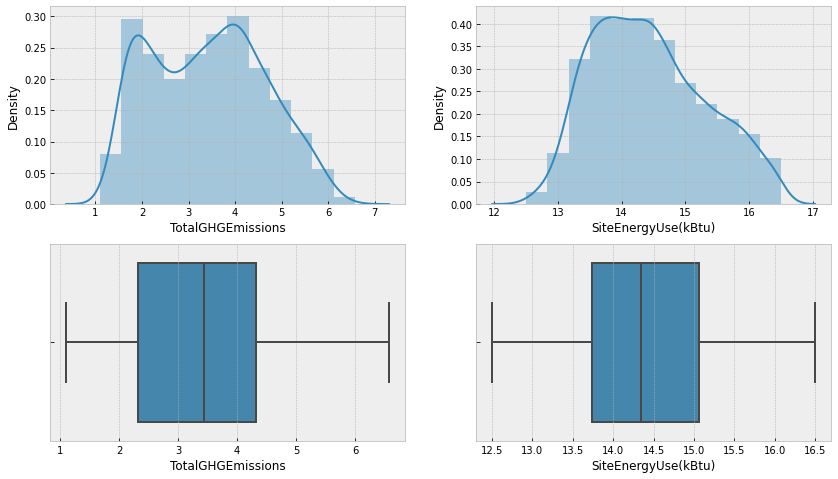

In [141]:
fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(seattle[label].apply(lambda x : np.log(1 + x)), bins=int(1 + np.log2(len(seattle))))
    plt.subplot(2,2,i+3)
    sns.boxplot(seattle[label].apply(lambda x : np.log(1 + x)), orient="v")
plt.show()

In [142]:
seattle.shape

(3128, 29)

In [143]:
seattle['BuildingType'].value_counts()

RESIDENTIAL       1697
NONRESIDENTIAL    1332
SCHOOL              99
Name: BuildingType, dtype: int64

**Nous devons etablir nos predictions uniquement sur les batiments non residentiel, filtrage sur Multifamily**

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)
Il faut donc supprimer les categories habitations dans notre dataset

In [144]:
seattle = seattle[(seattle['BuildingType'].str.contains("NONRESIDENTIAL")) | (seattle['BuildingType'].str.contains("SCHOOL"))]

In [145]:
seattle.shape

(1431, 29)

**Transformation logarithmiques des variables cibles, cette transformation seras faite plus tard , dans notre pipeline de modelisation**

In [146]:
# seattle[["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]] = seattle.loc[:, ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]].apply(lambda x: np.log(1 + x))

**Separation de nos variables inutiles pour la prediction**

In [147]:
identifiant_columns = ['OSEBuildingID',
                       'Address',
                       'ZipCode',
                       'State',
                       'ListOfAllPropertyUseTypes',
                       'ComplianceStatus',
                       'City',
                       'DefaultData',
                       'CouncilDistrictCode']
seattle.drop(seattle[identifiant_columns], axis=1, inplace = True)

In [148]:
seattle.columns

Index(['DataYear', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseType',
       'ENERGYSTARScore', 'TotalGHGEmissions', 'Latitude', 'Longitude',
       'BuildingAge', 'Electricity', 'NaturalGas', 'SteamUse',
       'GFAPerBuilding', 'GFAPerFloor', 'GFABuildingRate', 'GFAParkingRate',
       'SiteEnergyUse(kBtu)'],
      dtype='object')

In [149]:
seattle.shape

(1431, 20)

In [150]:
qualitativescol = seattle.select_dtypes(include=['object'])
quantitativescol = seattle.select_dtypes(include=['float'])

In [151]:
# qualitativescol = qualitativescol.drop(['ListOfAllPropertyUseTypes'], axis=1)
qualitativescol.nunique()

BuildingType               2
PrimaryPropertyType       13
Neighborhood              13
LargestPropertyUseType    43
dtype: int64

In [152]:
sorted(list(qualitativescol.columns))

['BuildingType',
 'LargestPropertyUseType',
 'Neighborhood',
 'PrimaryPropertyType']

In [153]:
sorted(list(quantitativescol.columns))

['BuildingAge',
 'ENERGYSTARScore',
 'Electricity',
 'GFABuildingRate',
 'GFAParkingRate',
 'GFAPerBuilding',
 'GFAPerFloor',
 'Latitude',
 'Longitude',
 'NaturalGas',
 'NumberofBuildings',
 'NumberofFloors',
 'SiteEnergyUse(kBtu)',
 'SteamUse',
 'TotalGHGEmissions']

In [154]:
seattle.to_csv('seattle_cleaned.csv')

**astuce du passage au log**

En passant les données à l'échelle logarithmique, nous obtenons une distribution normale des données à prédire. Nous allons donc appliquer cette transformation dans notre pipeline 
